In [1]:
import glob
from datetime import datetime, timedelta
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from grids import Grid, draw_grid
from queens import Queens
from BPSolver import BPSolver

In [2]:

def imshow(images, col_qty=5, figsize=(10, 15), axis_off=True):
    """"
    images: [(title1, image1), (title2, image2), (title3, image3), ... ]
    col_qty: number of columns in the grid of images to show
    figsize: sisze of each image
    """
    img_count = len(images)

    row_qty= (img_count // col_qty) + (img_count % col_qty > 0)

    fig, axes = plt.subplots(row_qty, col_qty, figsize=figsize)

    axes = np.array(axes).flatten()  # access the array with just one index

    for i, (title, img) in enumerate(images):
        if len(img.shape) == 3:  # Color image (BGR)
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:  # Gray image
            axes[i].imshow(img, cmap = "gray")

        axes[i].set_title(title)
        if axis_off:
            axes[i].axis("off")

    # Hide remaining axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [3]:
def imshow_1(title, image, figsize=(10, 5)):
    
    fig, ax = plt.subplots(figsize=figsize)

    if len(image.shape) == 3:  # Imagen en color (BGR)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:  # Imagen en escala de grises
        ax.imshow(image, cmap = "gray")
    
    ax.set_title(title)
    # axes[0].axis("off")

    plt.tight_layout()
    plt.show()


In [4]:
def imshow_2(tit1, img1, tit2, img2, figsize=(10, 5)):
    # Mostrar dos imagenes
    fig, axes = plt.subplots(1, 2, figsize=figsize)  # 1 fila, 2 columnas

    if len(img1.shape) == 3:  # Imagen en color (BGR)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        cmap1 = None
    else:
        cmap1 = 'gray'

    if len(img2.shape) == 3:  # Imagen en color (BGR)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        cmap2 = None
    else:
        cmap2 = 'gray'

    # Imagen 1
    axes[0].imshow(img1, cmap=cmap1)
    axes[0].set_title(tit1)
    # axes[0].axis("off")

    # Imagen procesada
    axes[1].imshow(img2, cmap=cmap2)
    axes[1].set_title(tit2)
    # axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
def update_pbar(pbar, start_time, done, total, results):
    pbar.update(1)
    elapsed_time = datetime.now() - start_time
    estimated_total = (elapsed_time / done) * total
    remaining_time = estimated_total - elapsed_time
    finish_time = datetime.now() + remaining_time
    pbar.set_postfix(ETA=finish_time.strftime("%H:%M:%S"), Status=results)

In [6]:
# Load image

gr = Grid(image_path='./img/queens-IMG_9519.PNG')

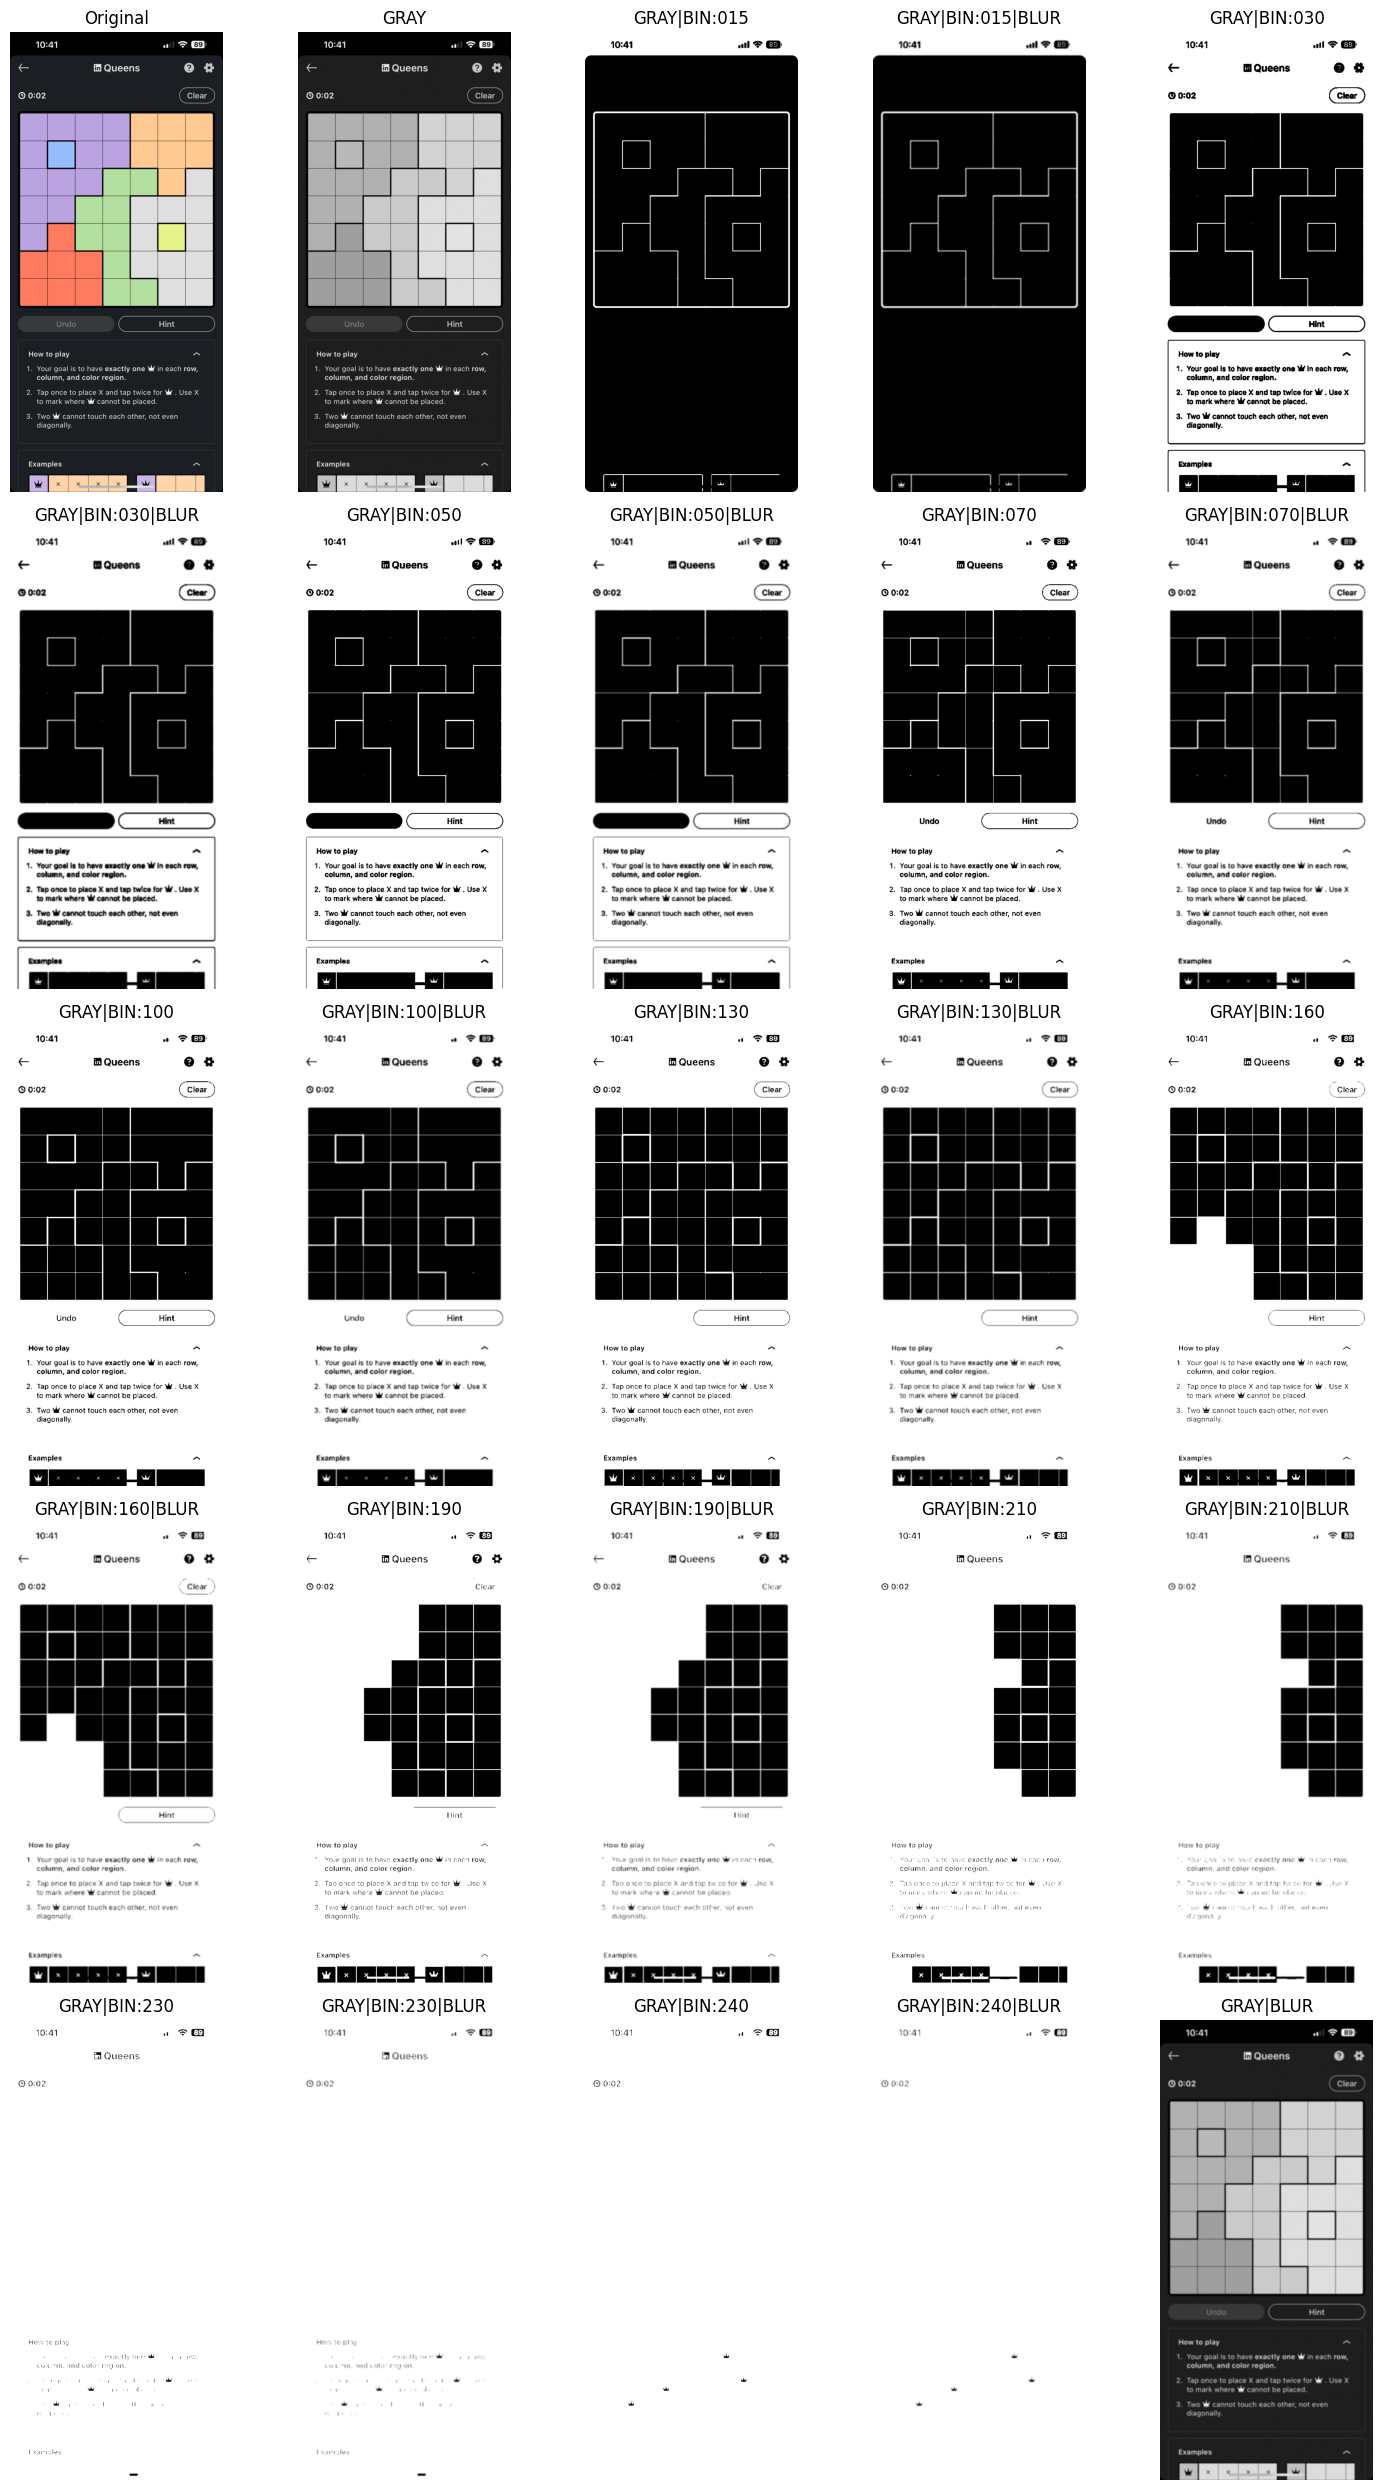

In [7]:
# Show original and pre-processed images
gr.preprocess_image(resize_width=500)
images = [("Original", gr.image)] + sorted(gr.work_imgs.items())
imshow(images, col_qty=5, figsize=(15, 25))

In [8]:
# Find the grid (show the process)
output = gr.find_grid(
    min_line_length = 300, 
    max_line_gap = 8, 
    max_groupping_dist = 3, 
    min_valid_n=5,
    max_valid_n=15,
    show_process=True
)

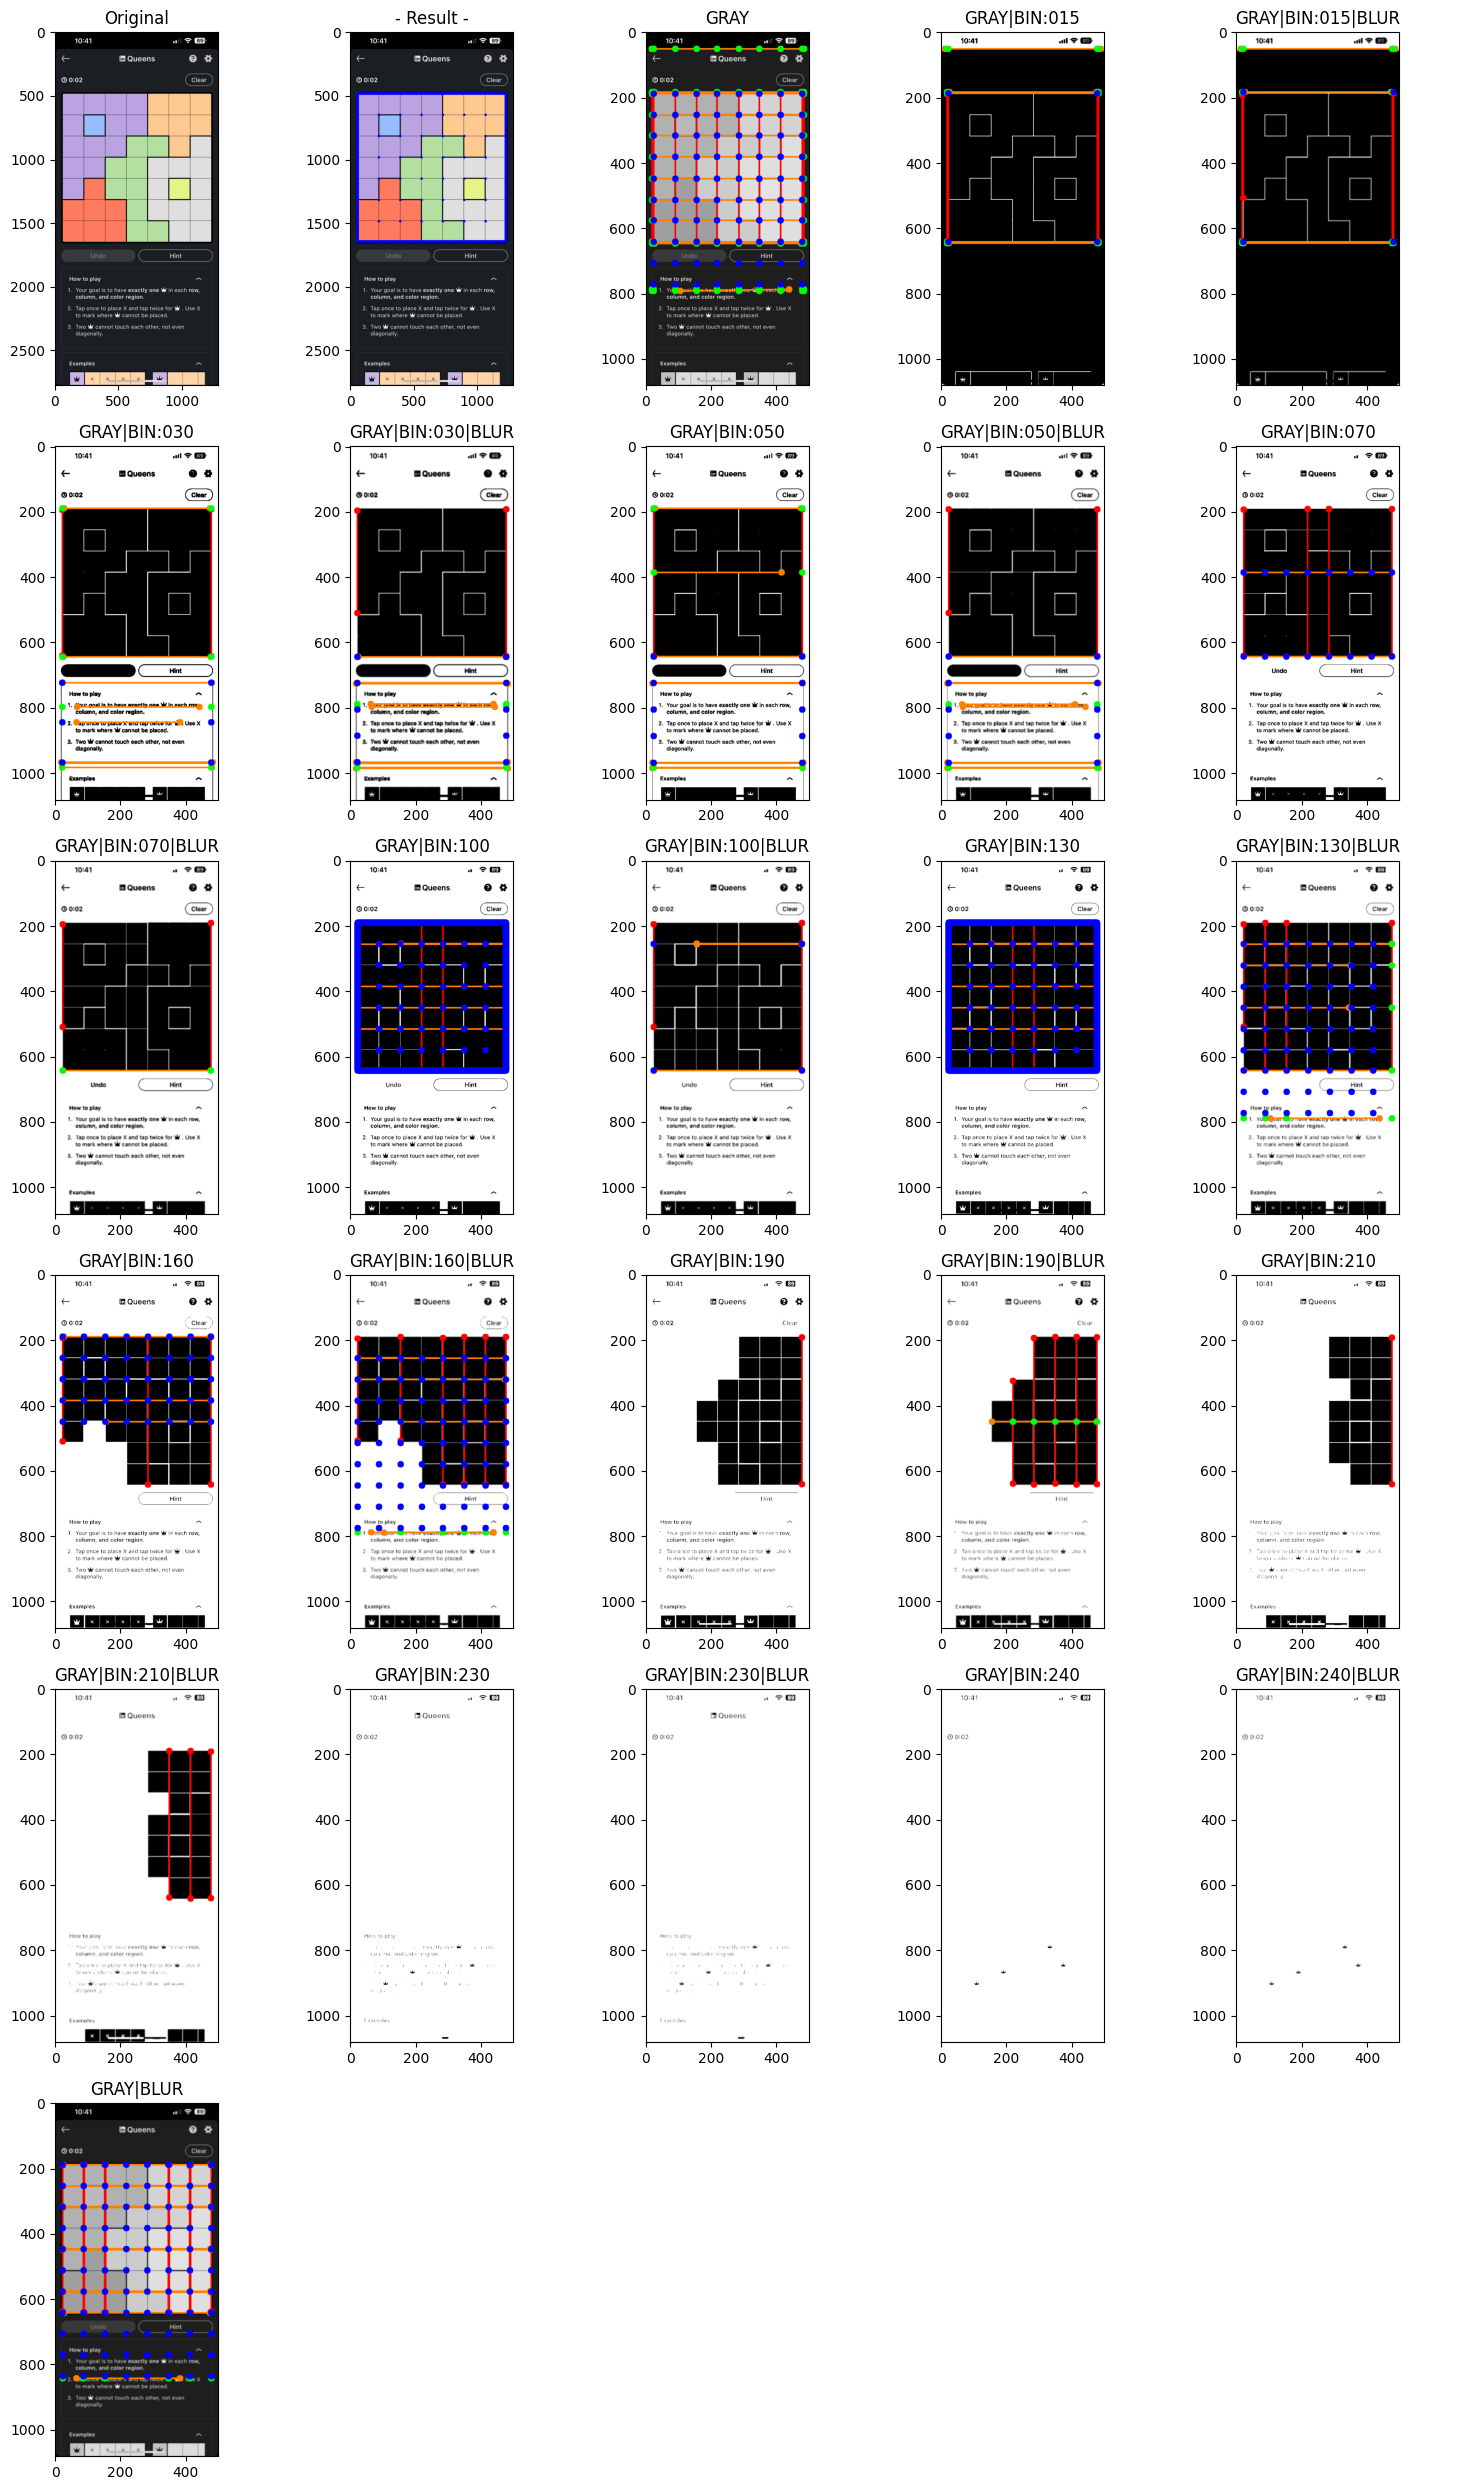

In [9]:
# Show the results for each pre-process

images = [("Original", gr.image)] + sorted(output.items())
imshow(images, axis_off=False, figsize=(15, 25))

In [10]:
# Process a bunch of images and analyze the Grid class parameters that have more chance to find the grid

threshold_values = [70, 100, 130, 160]
min_line_length = [300, 350, 400]
max_line_gap = [8, 12]
max_groupping_dist = 3

columns = [
    'filename', 'best_n', 'best_label', 'max_cluster_size', 
    'pre-proc', 'in_final_set', 'label', 'n', 'height', 'width',
    'min_line_length', 'max_line_gap', 'max_groupping_dist', 'cluster_size'
]
grids = pd.DataFrame(columns=columns)
show = []
results = ''
filenames = sorted(glob.glob('./img/*.*'))
start_time, done = datetime.now(), 0
with tqdm(total=len(filenames), desc="Progress", unit="iter") as pbar:
    for filename in filenames:
        gr = Grid(filename)
        gr.preprocess_image(resize_width=500, threshold_values=threshold_values)
        gr.find_grid(
            min_line_length=min_line_length, 
            max_line_gap=max_line_gap,
            max_groupping_dist=max_groupping_dist,
            min_valid_n=6, max_valid_n=16
        )
        if gr.n:
            df = pd.DataFrame(gr.all_grids)
        else:
            df = pd.DataFrame([{
                    'pre-proc': '', 
                    'in_final_set': False, 
                    'label': 0, 
                    'n': 0, 
                    'height': 0,
                    'width': 0,
                    'min_line_length': 0, 
                    'max_line_gap': 0, 
                    'max_groupping_dist': 0, 
                    'cluster_size': 0
            }])
        df['filename'] = gr.image_path.replace('./img/', '', 1)
        df['best_n'] = gr.n if gr.n else 0
        df['best_label'] = gr.best_label if gr.best_label else 0
        df['max_cluster_size'] = gr.max_cluster_size if gr.max_cluster_size else 0
        show.append((
                f"n: {gr.n}-label: {gr.best_label}\n{gr.image_path.replace('./img/', '', 1)}",
                draw_grid(gr.image, gr.x_axis, gr.y_axis)
        ))
        for c in set(columns) - set(df.columns):
            df[c] = None
        df = df[columns]
        grids = pd.concat([grids, df]).reset_index(drop=True)
        results += "✔" if gr.n > 0 else "✖"
        done += 1
        update_pbar(pbar, start_time, done, len(filenames), results)
        

Progress: 100%|██████████| 78/78 [00:49<00:00,  1.59iter/s, ETA=00:10:29, Status=✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✖✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔]


In [11]:
grids        

filename best_n best_label  \
0     queens - iru - PHOTO-2025-03-07-11-53-59.jpg      9          0   
1     queens - iru - PHOTO-2025-03-07-11-53-59.jpg      9          0   
2     queens - iru - PHOTO-2025-03-07-11-53-59.jpg      9          0   
3     queens - iru - PHOTO-2025-03-07-11-53-59.jpg      9          0   
4     queens - iru - PHOTO-2025-03-07-11-53-59.jpg      9          0   
...                                            ...    ...        ...   
1051  tango-Screenshot 2025-03-03 at 11.36.20.jpeg      7          0   
1052                           tango-image001.jpeg      7          0   
1053                           tango-image001.jpeg      7          0   
1054                           tango-image001.jpeg      7          0   
1055                           tango-image001.jpeg      7          0   

     max_cluster_size           pre-proc in_final_set label  n height width  \
0                  15               GRAY         True     0  9   1084   500   
1                  15               GRAY         True     0  9   1084   500   
2                  15               GRAY         True     0  9   1084   500   
3                  15       GRAY|BIN:070         True     0  9   1084   500   
4                  15       GRAY|BIN:100         True     0  9   1084   500   
...               ...                ...          ...   ... ..    ...   ...   
1051                6  GRAY|BIN:070|BLUR         True     0  7   1082   500   
1052                4       GRAY|BIN:070         True     0  7   1081   500   
1053                4       GRAY|BIN:070         True     0  7   1081   500   
1054                4  GRAY|BIN:070|BLUR         True     0  7   1081   500   
1055                4  GRAY|BIN:070|BLUR         True     0  7   1081   500   

     min_line_length max_line_gap max_groupping_dist cluster_size  
0                350            8                  3           15  
1                400            8                  3           15  
2                400           12                  3           15  
3                300            8                  3           15  
4                300            8                  3           15  
...              ...          ...                ...          ...  
1051             400           12                  3            6  
1052             300            8                  3            4  
1053             350            8                  3            4  
1054             400            8                  3            4  
1055             400           12                  3            4  

[1056 rows x 14 columns]

In [12]:
# For which files could a valid grid not be found?

not_solved = grids[grids['best_n']==0]['filename'].to_list()
solved = grids[grids['best_n']!=0]['filename'].unique()
not_solved, len(not_solved), len(solved)

(['queens-IMG_9569.PNG'], 1, 77)

In [13]:
# Make a list of parameters with the files that each of them managed to resolve

param_cols = ['pre-proc', 'min_line_length', 'max_line_gap', 'max_groupping_dist']
grids['in_final_set'] = grids['in_final_set'].fillna(False).astype(bool)
params = grids[grids['in_final_set']].groupby(param_cols)[param_cols+['filename']].apply(lambda grp: set(grp['filename'].unique()))
params = params.rename('filenames').reset_index()
params['qty'] = params['filenames'].apply(len)
params = params.sort_values(by='qty', ascending=False)
params

/tmp/ipykernel_168673/1920375287.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grids['in_final_set'] = grids['in_final_set'].fillna(False).astype(bool)


pre-proc  min_line_length  max_line_gap  max_groupping_dist  \
17       GRAY|BIN:100              300             8                   3   
19       GRAY|BIN:100              350             8                   3   
21       GRAY|BIN:100              400             8                   3   
22       GRAY|BIN:100              400            12                   3   
31       GRAY|BIN:130              400            12                   3   
52          GRAY|BLUR              400            12                   3   
30       GRAY|BIN:130              400             8                   3   
26       GRAY|BIN:130              300             8                   3   
51          GRAY|BLUR              400             8                   3   
28       GRAY|BIN:130              350             8                   3   
49          GRAY|BLUR              350             8                   3   
4                GRAY              400             8                   3   
5                GRAY              400            12                   3   
6        GRAY|BIN:070              300             8                   3   
8        GRAY|BIN:070              350             8                   3   
2                GRAY              350             8                   3   
11       GRAY|BIN:070              400            12                   3   
10       GRAY|BIN:070              400             8                   3   
35  GRAY|BIN:130|BLUR              400            12                   3   
15  GRAY|BIN:070|BLUR              400             8                   3   
16  GRAY|BIN:070|BLUR              400            12                   3   
46  GRAY|BIN:160|BLUR              400            12                   3   
0                GRAY              300             8                   3   
36       GRAY|BIN:160              300             8                   3   
38       GRAY|BIN:160              350             8                   3   
41       GRAY|BIN:160              400            12                   3   
40       GRAY|BIN:160              400             8                   3   
29       GRAY|BIN:130              350            12                   3   
47          GRAY|BLUR              300             8                   3   
39       GRAY|BIN:160              350            12                   3   
20       GRAY|BIN:100              350            12                   3   
25  GRAY|BIN:100|BLUR              400            12                   3   
45  GRAY|BIN:160|BLUR              350            12                   3   
50          GRAY|BLUR              350            12                   3   
27       GRAY|BIN:130              300            12                   3   
3                GRAY              350            12                   3   
18       GRAY|BIN:100              300            12                   3   
33  GRAY|BIN:130|BLUR              300            12                   3   
34  GRAY|BIN:130|BLUR              350            12                   3   
32  GRAY|BIN:130|BLUR              300             8                   3   
13  GRAY|BIN:070|BLUR              300            12                   3   
7        GRAY|BIN:070              300            12                   3   
1                GRAY              300            12                   3   
9        GRAY|BIN:070              350            12                   3   
12  GRAY|BIN:070|BLUR              300             8                   3   
14  GRAY|BIN:070|BLUR              350            12                   3   
23  GRAY|BIN:100|BLUR              300             8                   3   
24  GRAY|BIN:100|BLUR              350            12                   3   
37       GRAY|BIN:160              300            12                   3   
44  GRAY|BIN:160|BLUR              350             8                   3   
43  GRAY|BIN:160|BLUR              300            12                   3   
42  GRAY|BIN:160|BLUR              300             8         

In [14]:
# Find out which parameters provided more solutions

filenames = set()
for i in range(len(params)):
    p = params.iloc[i]
    filenames = filenames | p['filenames']
    print(', '.join(f"{col}: {p[col]}" for col in param_cols), f"covered: {len(filenames)}")
    if len(filenames) == len(solved):
        break


pre-proc: GRAY|BIN:100, min_line_length: 300, max_line_gap: 8, max_groupping_dist: 3 covered: 58
pre-proc: GRAY|BIN:100, min_line_length: 350, max_line_gap: 8, max_groupping_dist: 3 covered: 58
pre-proc: GRAY|BIN:100, min_line_length: 400, max_line_gap: 8, max_groupping_dist: 3 covered: 58
pre-proc: GRAY|BIN:100, min_line_length: 400, max_line_gap: 12, max_groupping_dist: 3 covered: 59
pre-proc: GRAY|BIN:130, min_line_length: 400, max_line_gap: 12, max_groupping_dist: 3 covered: 60
pre-proc: GRAY|BLUR, min_line_length: 400, max_line_gap: 12, max_groupping_dist: 3 covered: 60
pre-proc: GRAY|BIN:130, min_line_length: 400, max_line_gap: 8, max_groupping_dist: 3 covered: 60
pre-proc: GRAY|BIN:130, min_line_length: 300, max_line_gap: 8, max_groupping_dist: 3 covered: 60
pre-proc: GRAY|BLUR, min_line_length: 400, max_line_gap: 8, max_groupping_dist: 3 covered: 61
pre-proc: GRAY|BIN:130, min_line_length: 350, max_line_gap: 8, max_groupping_dist: 3 covered: 61
pre-proc: GRAY|BLUR, min_line_len

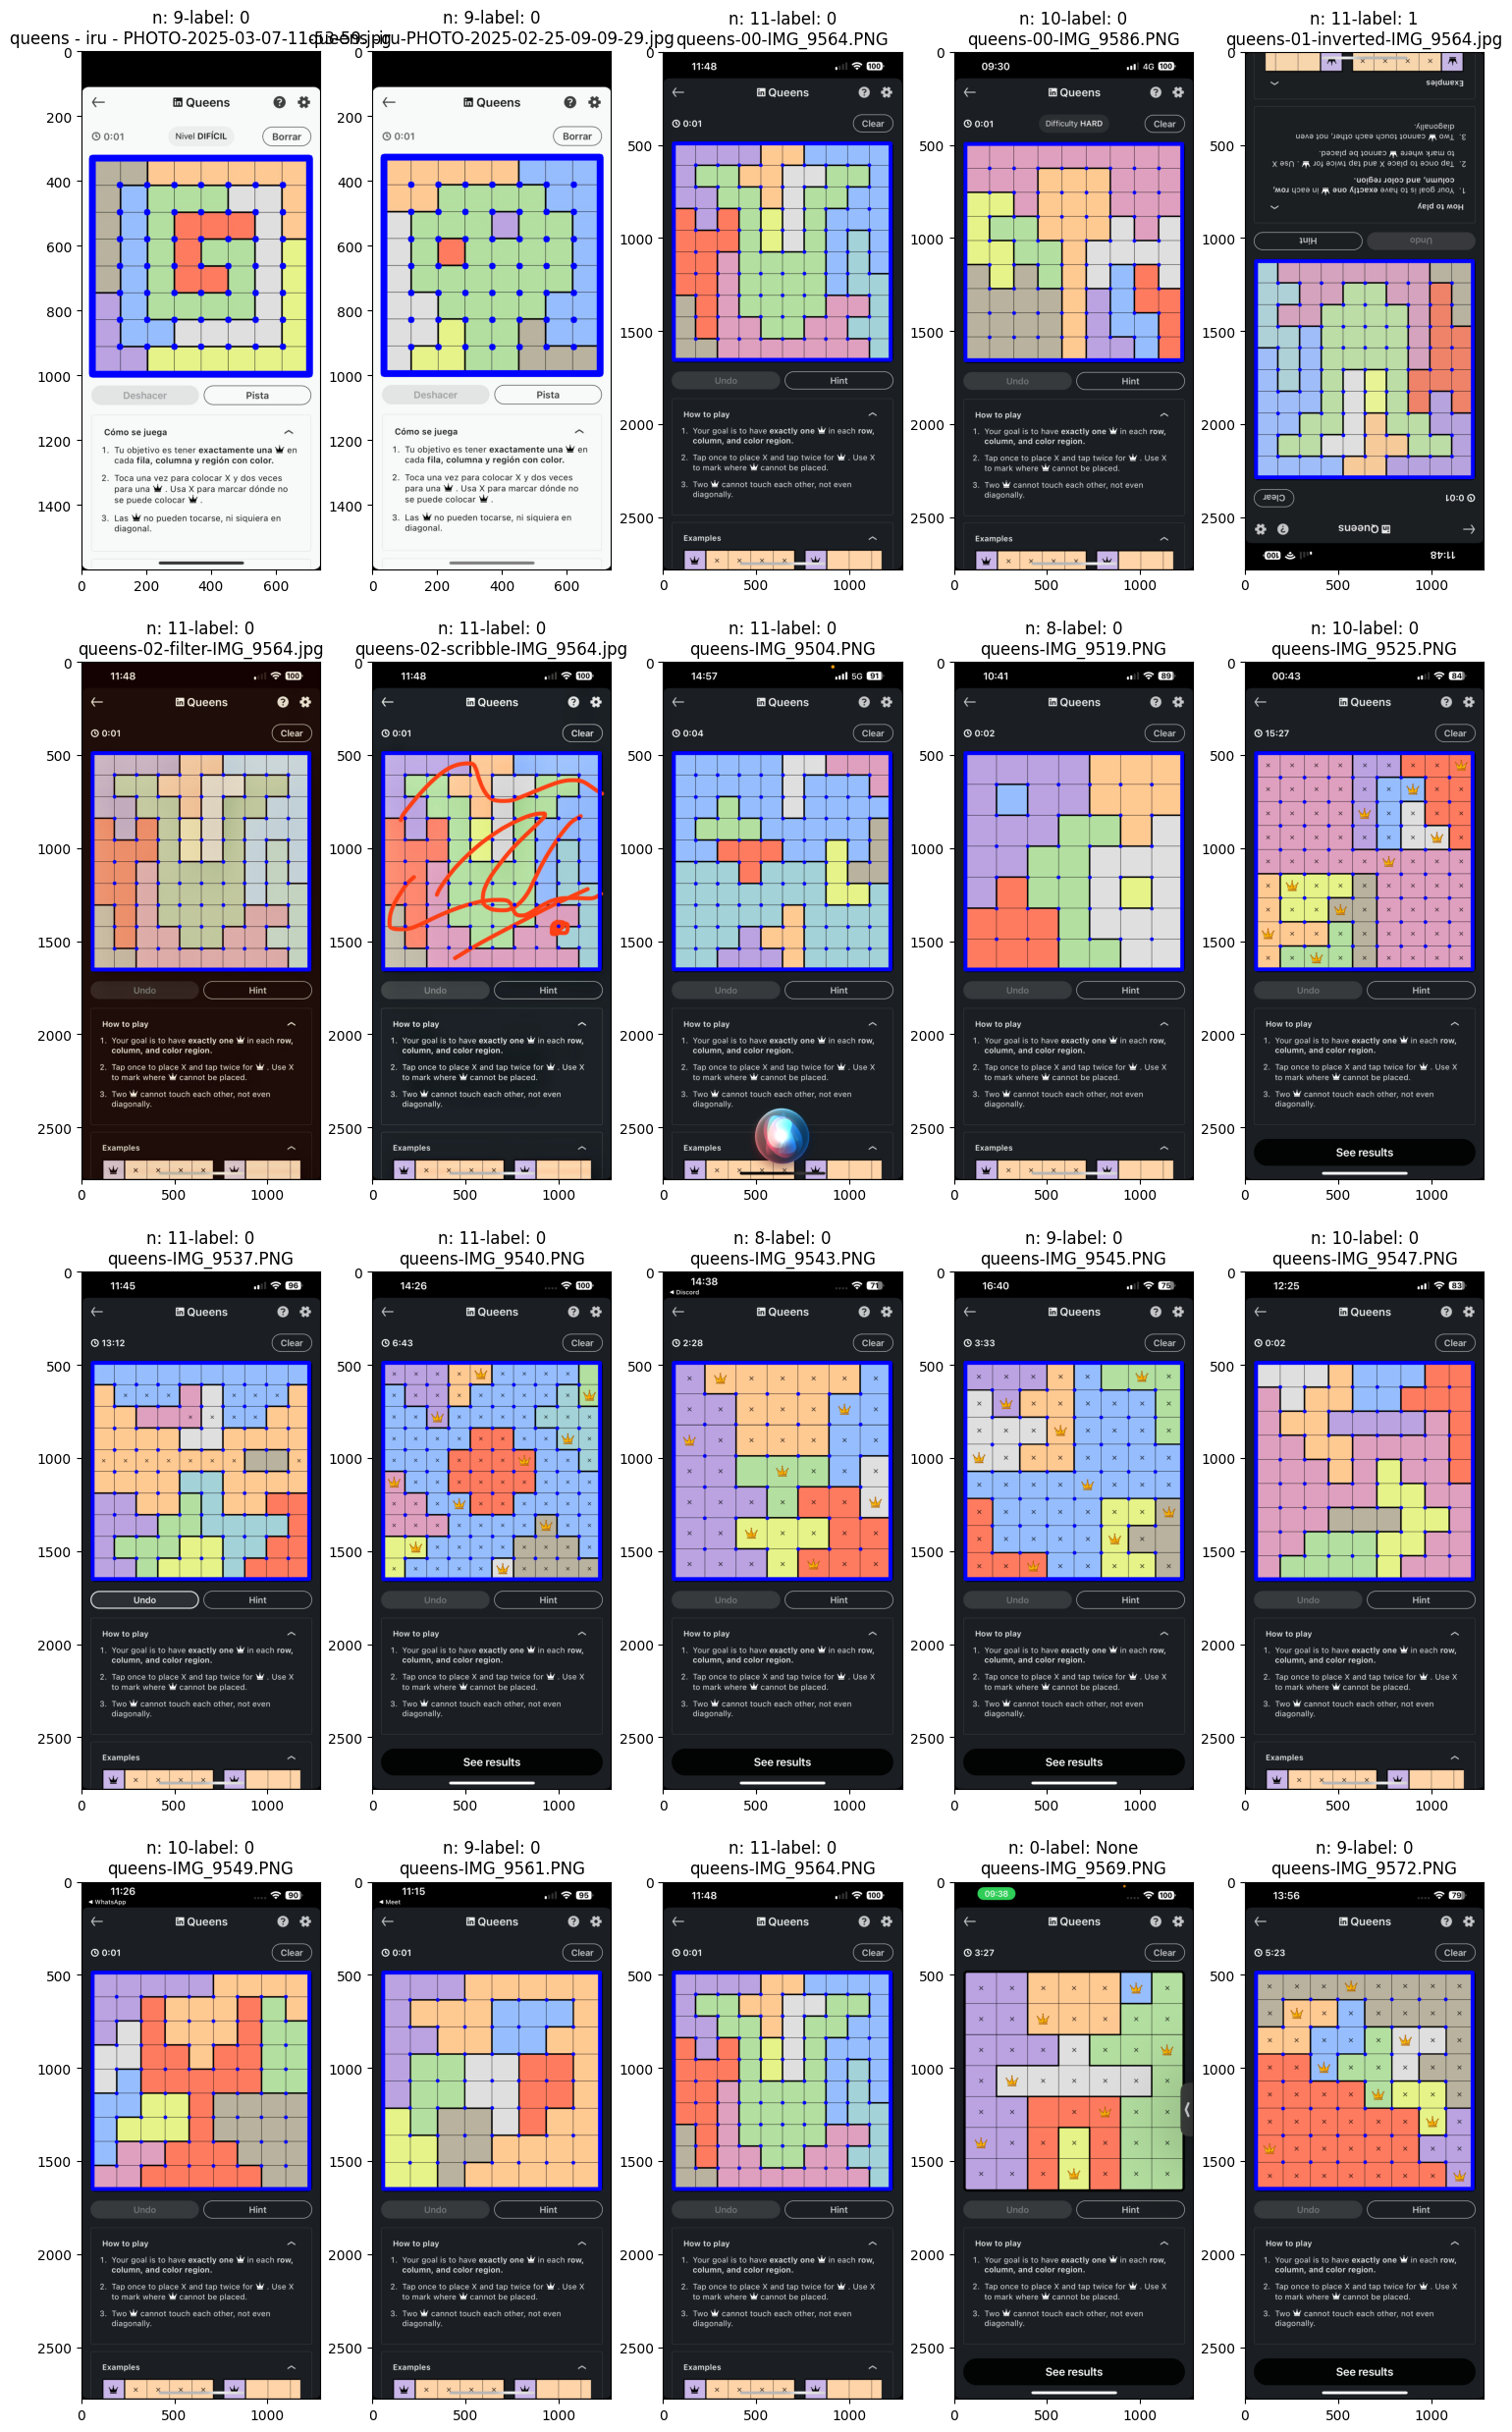

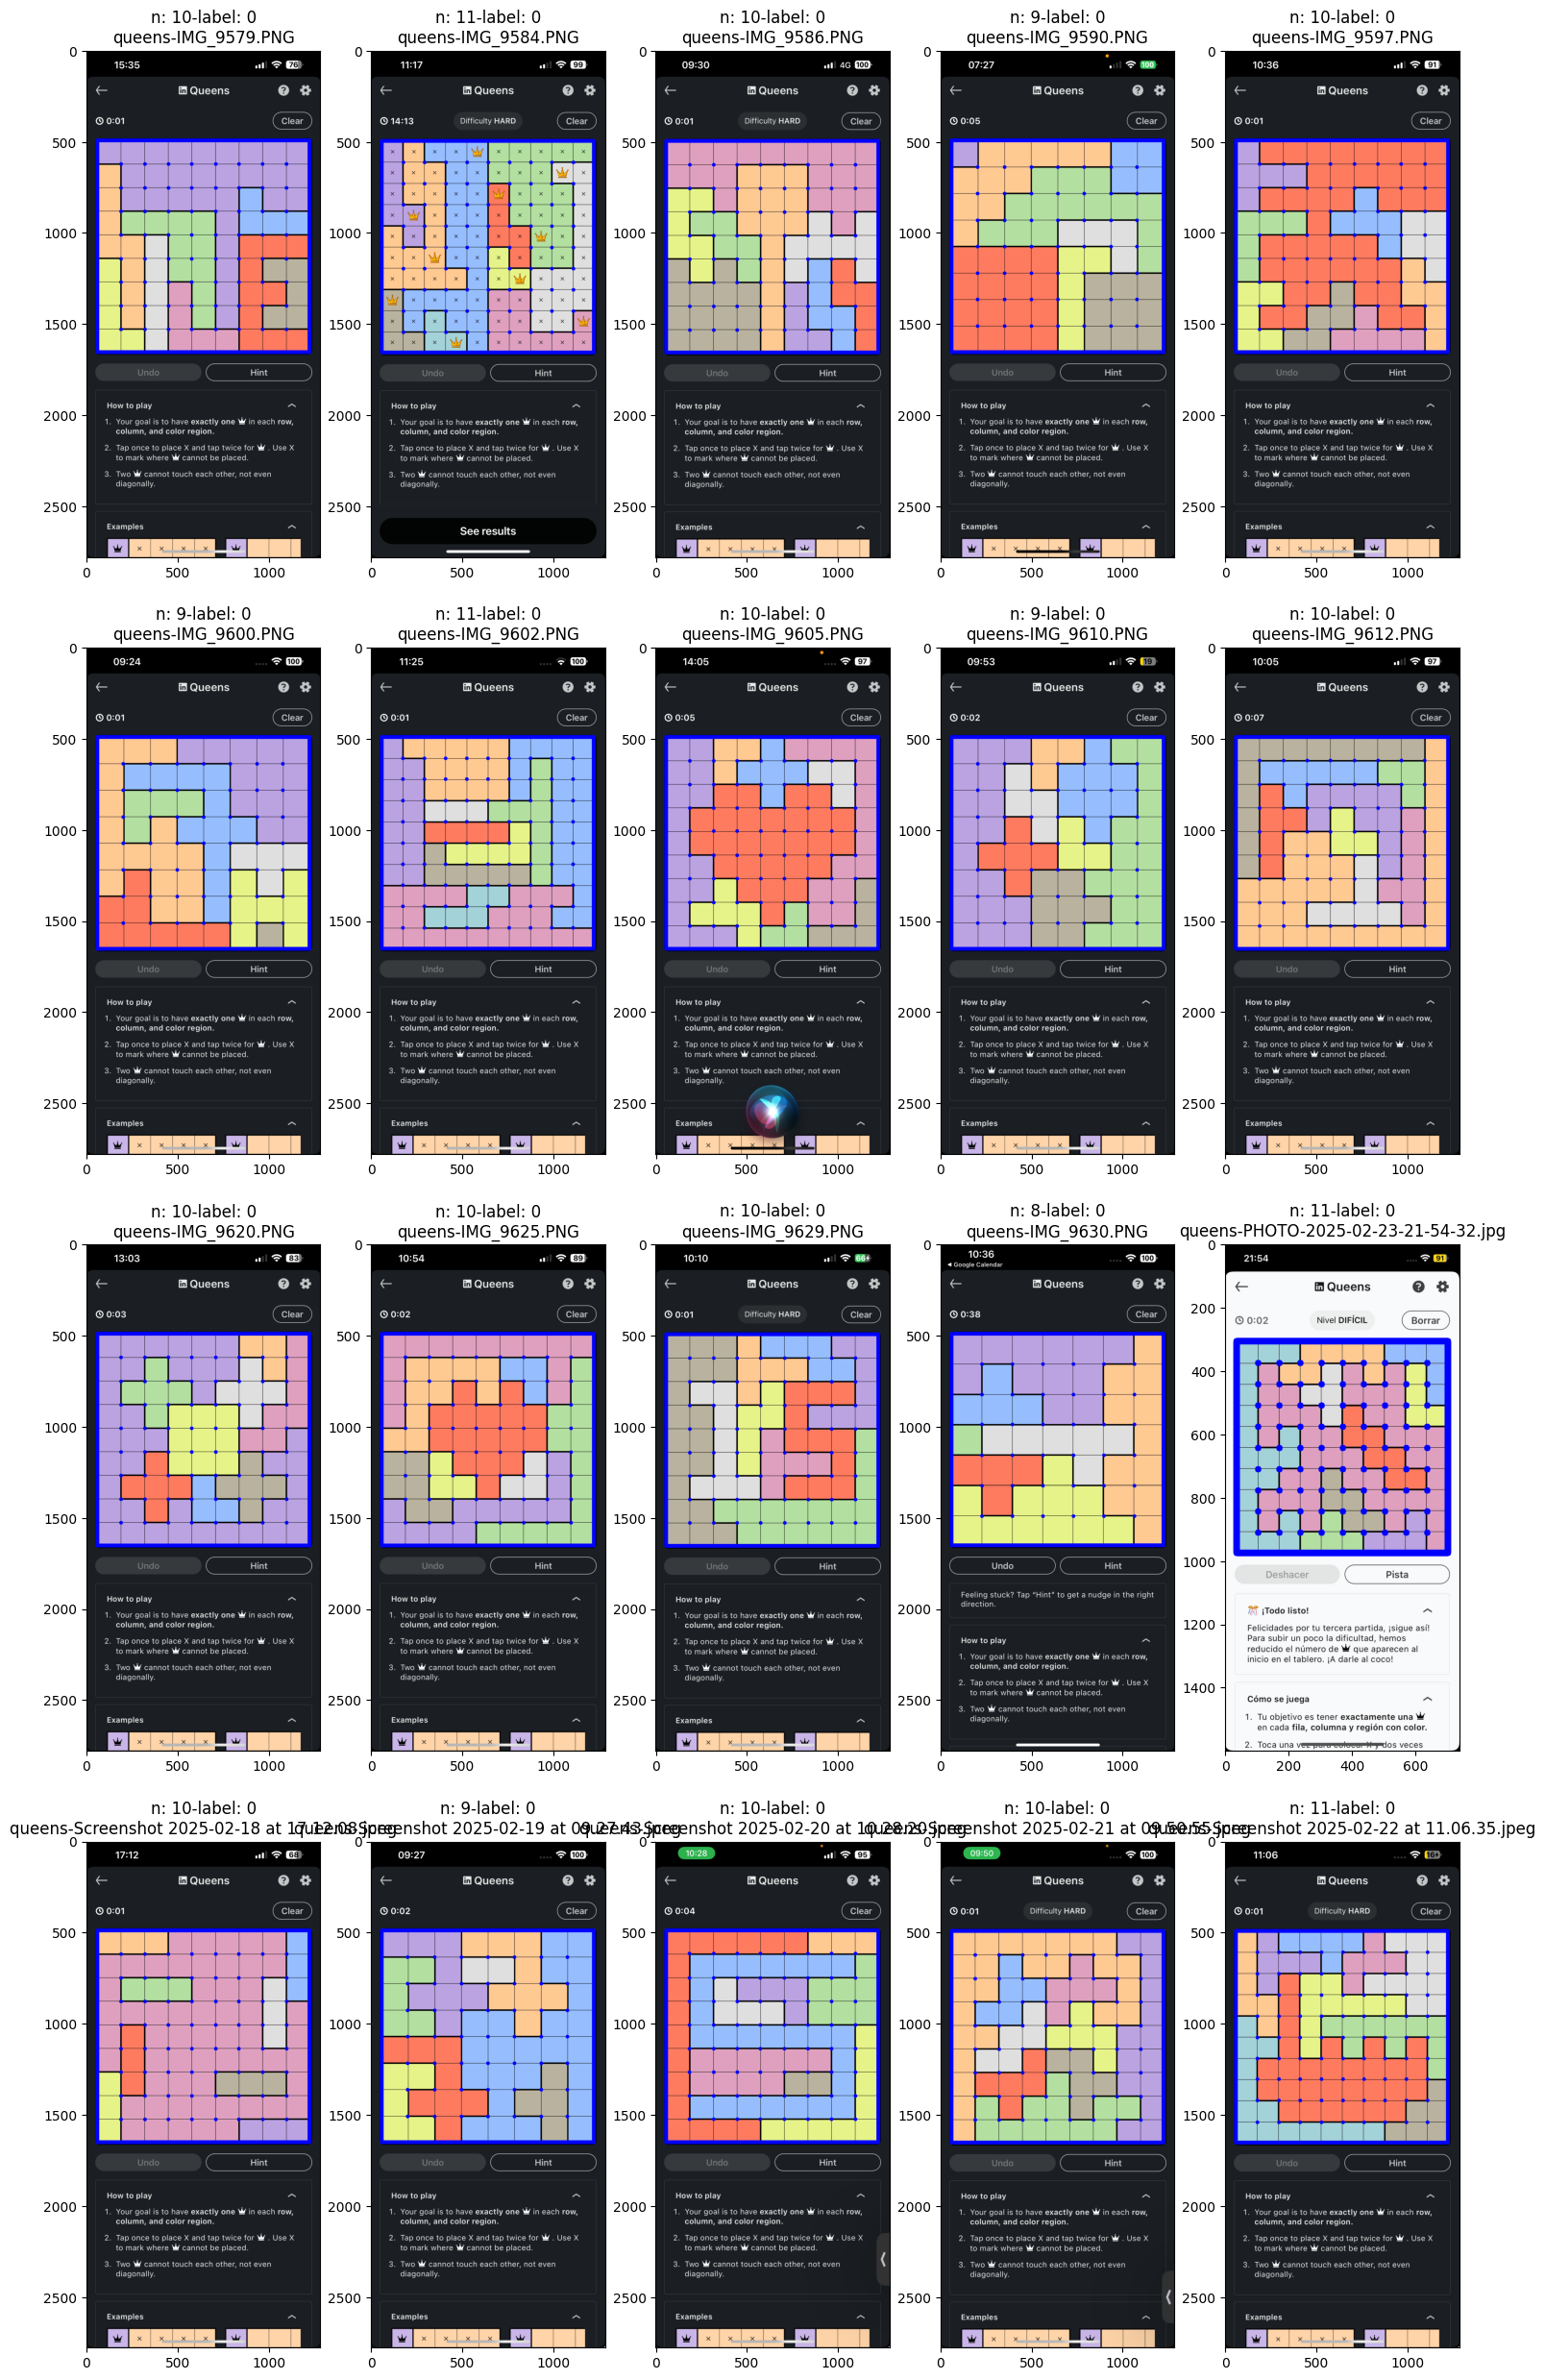

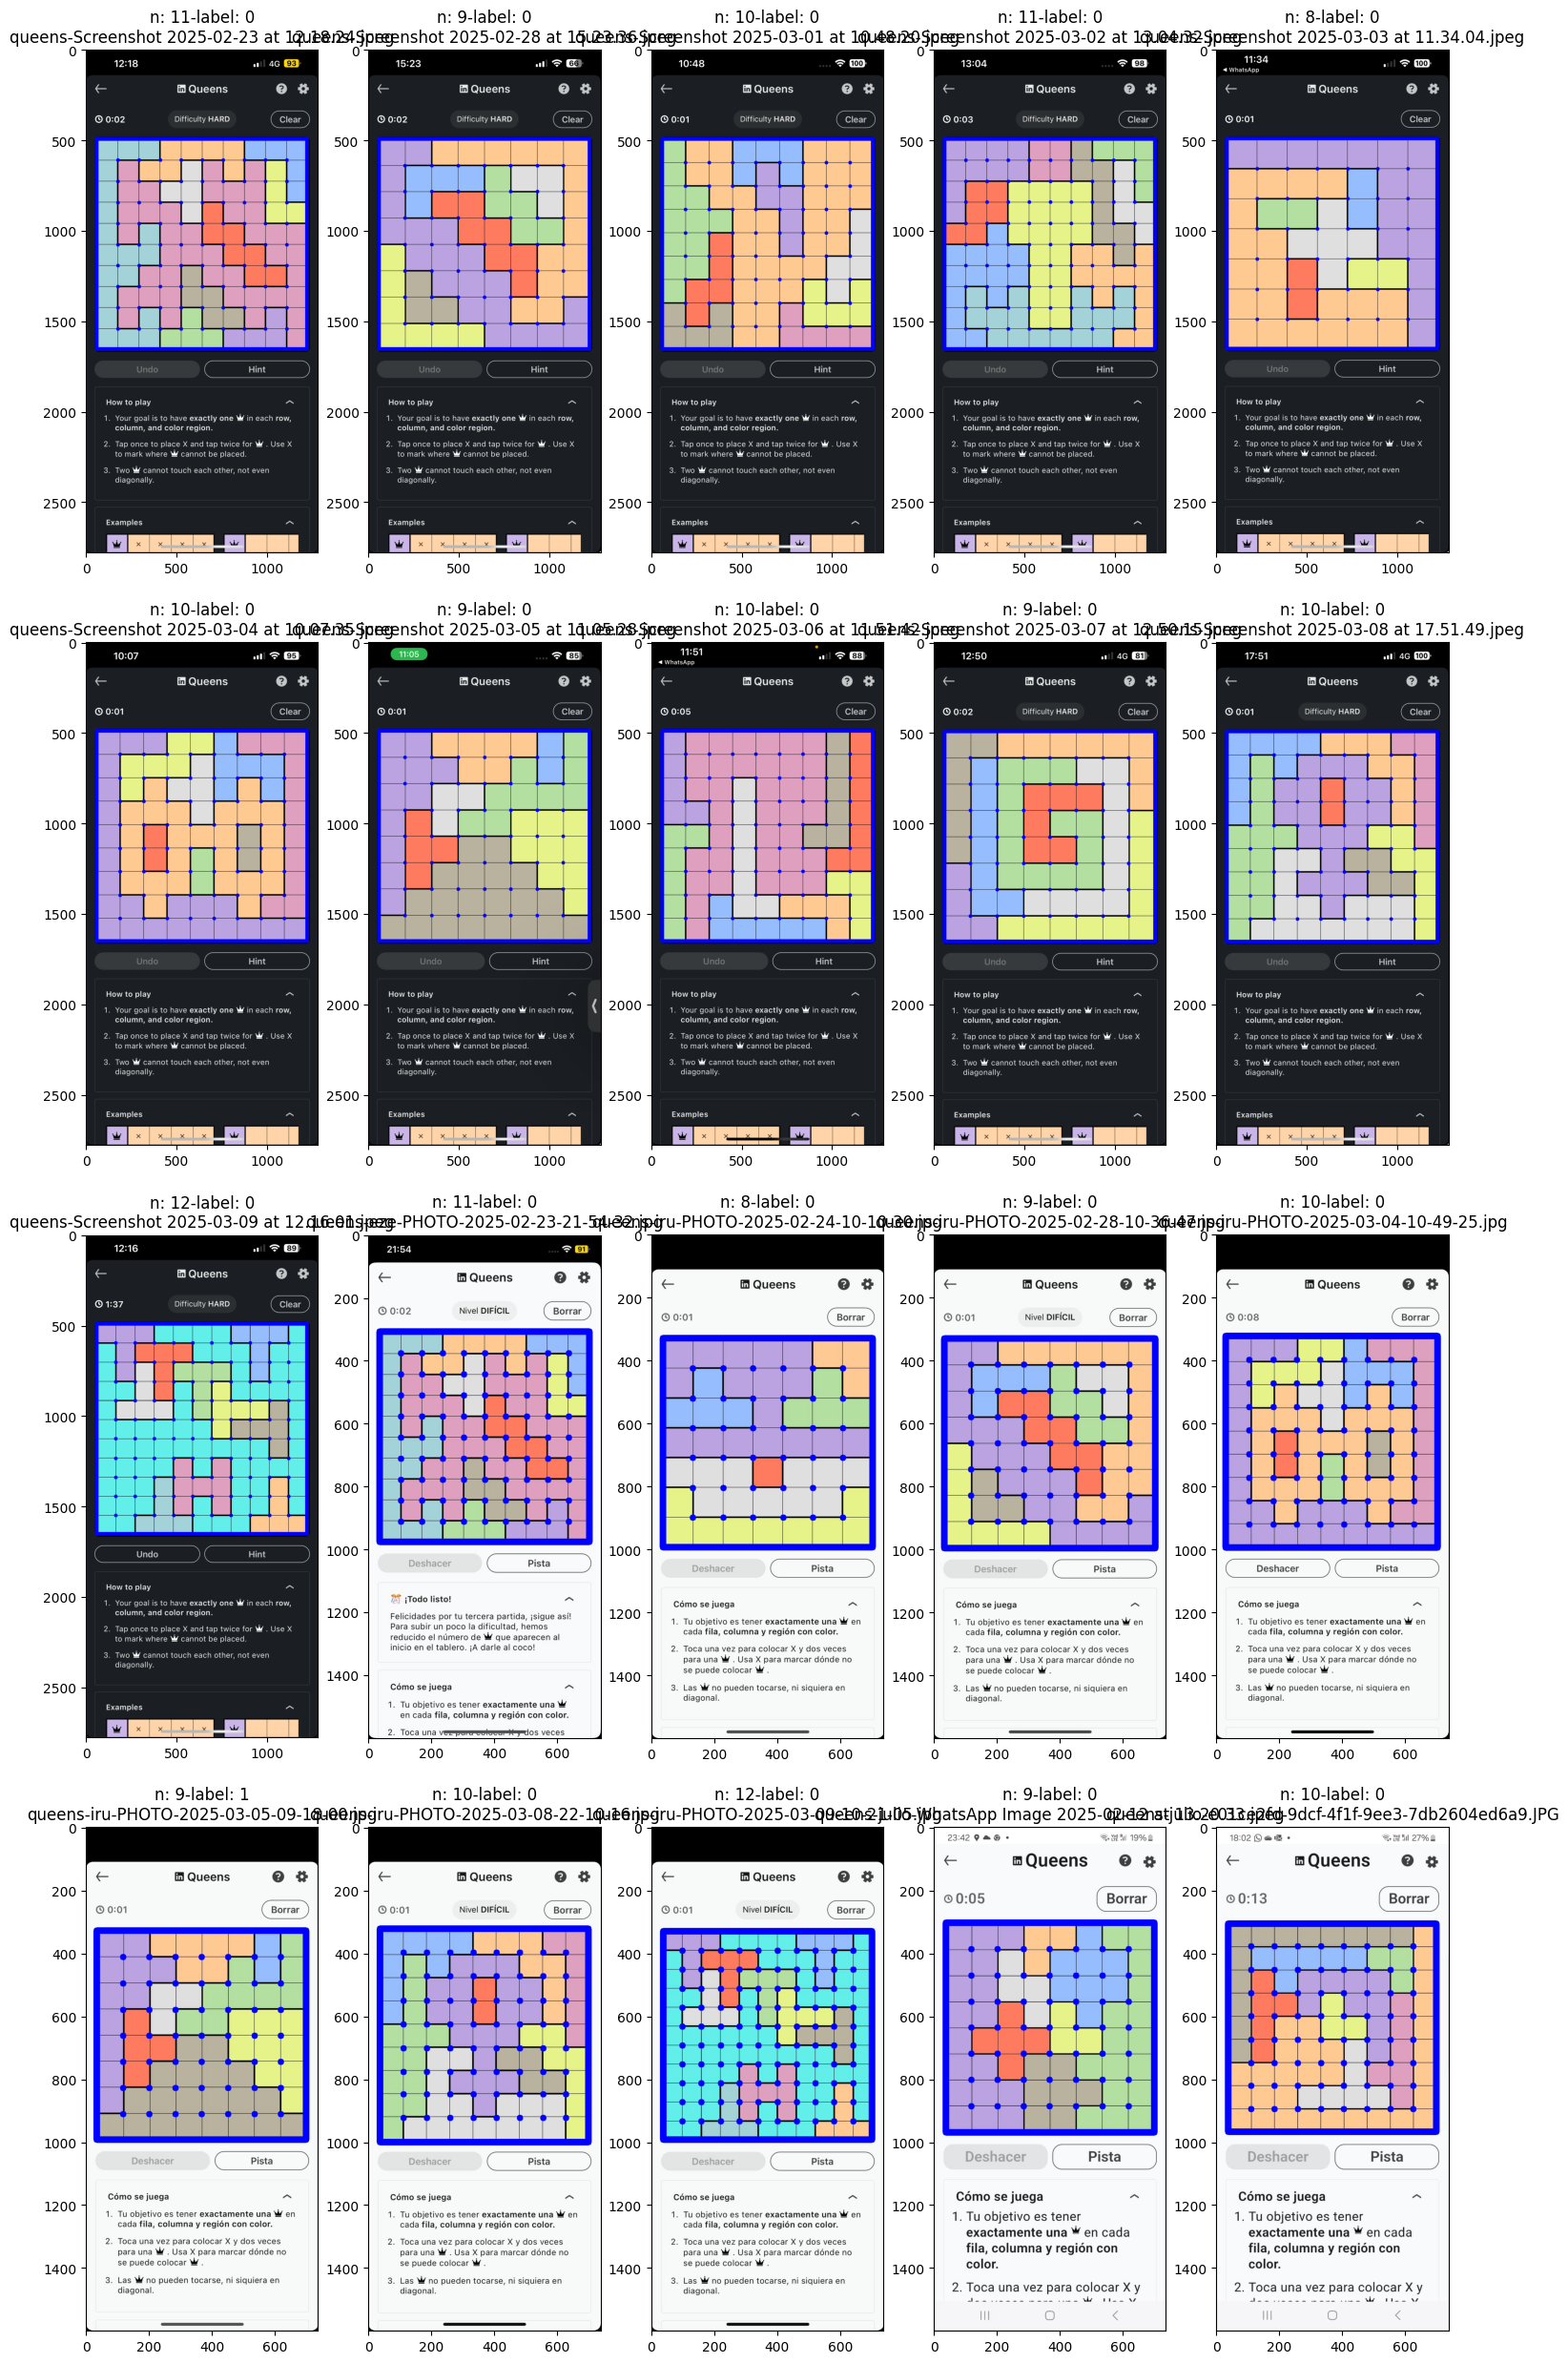

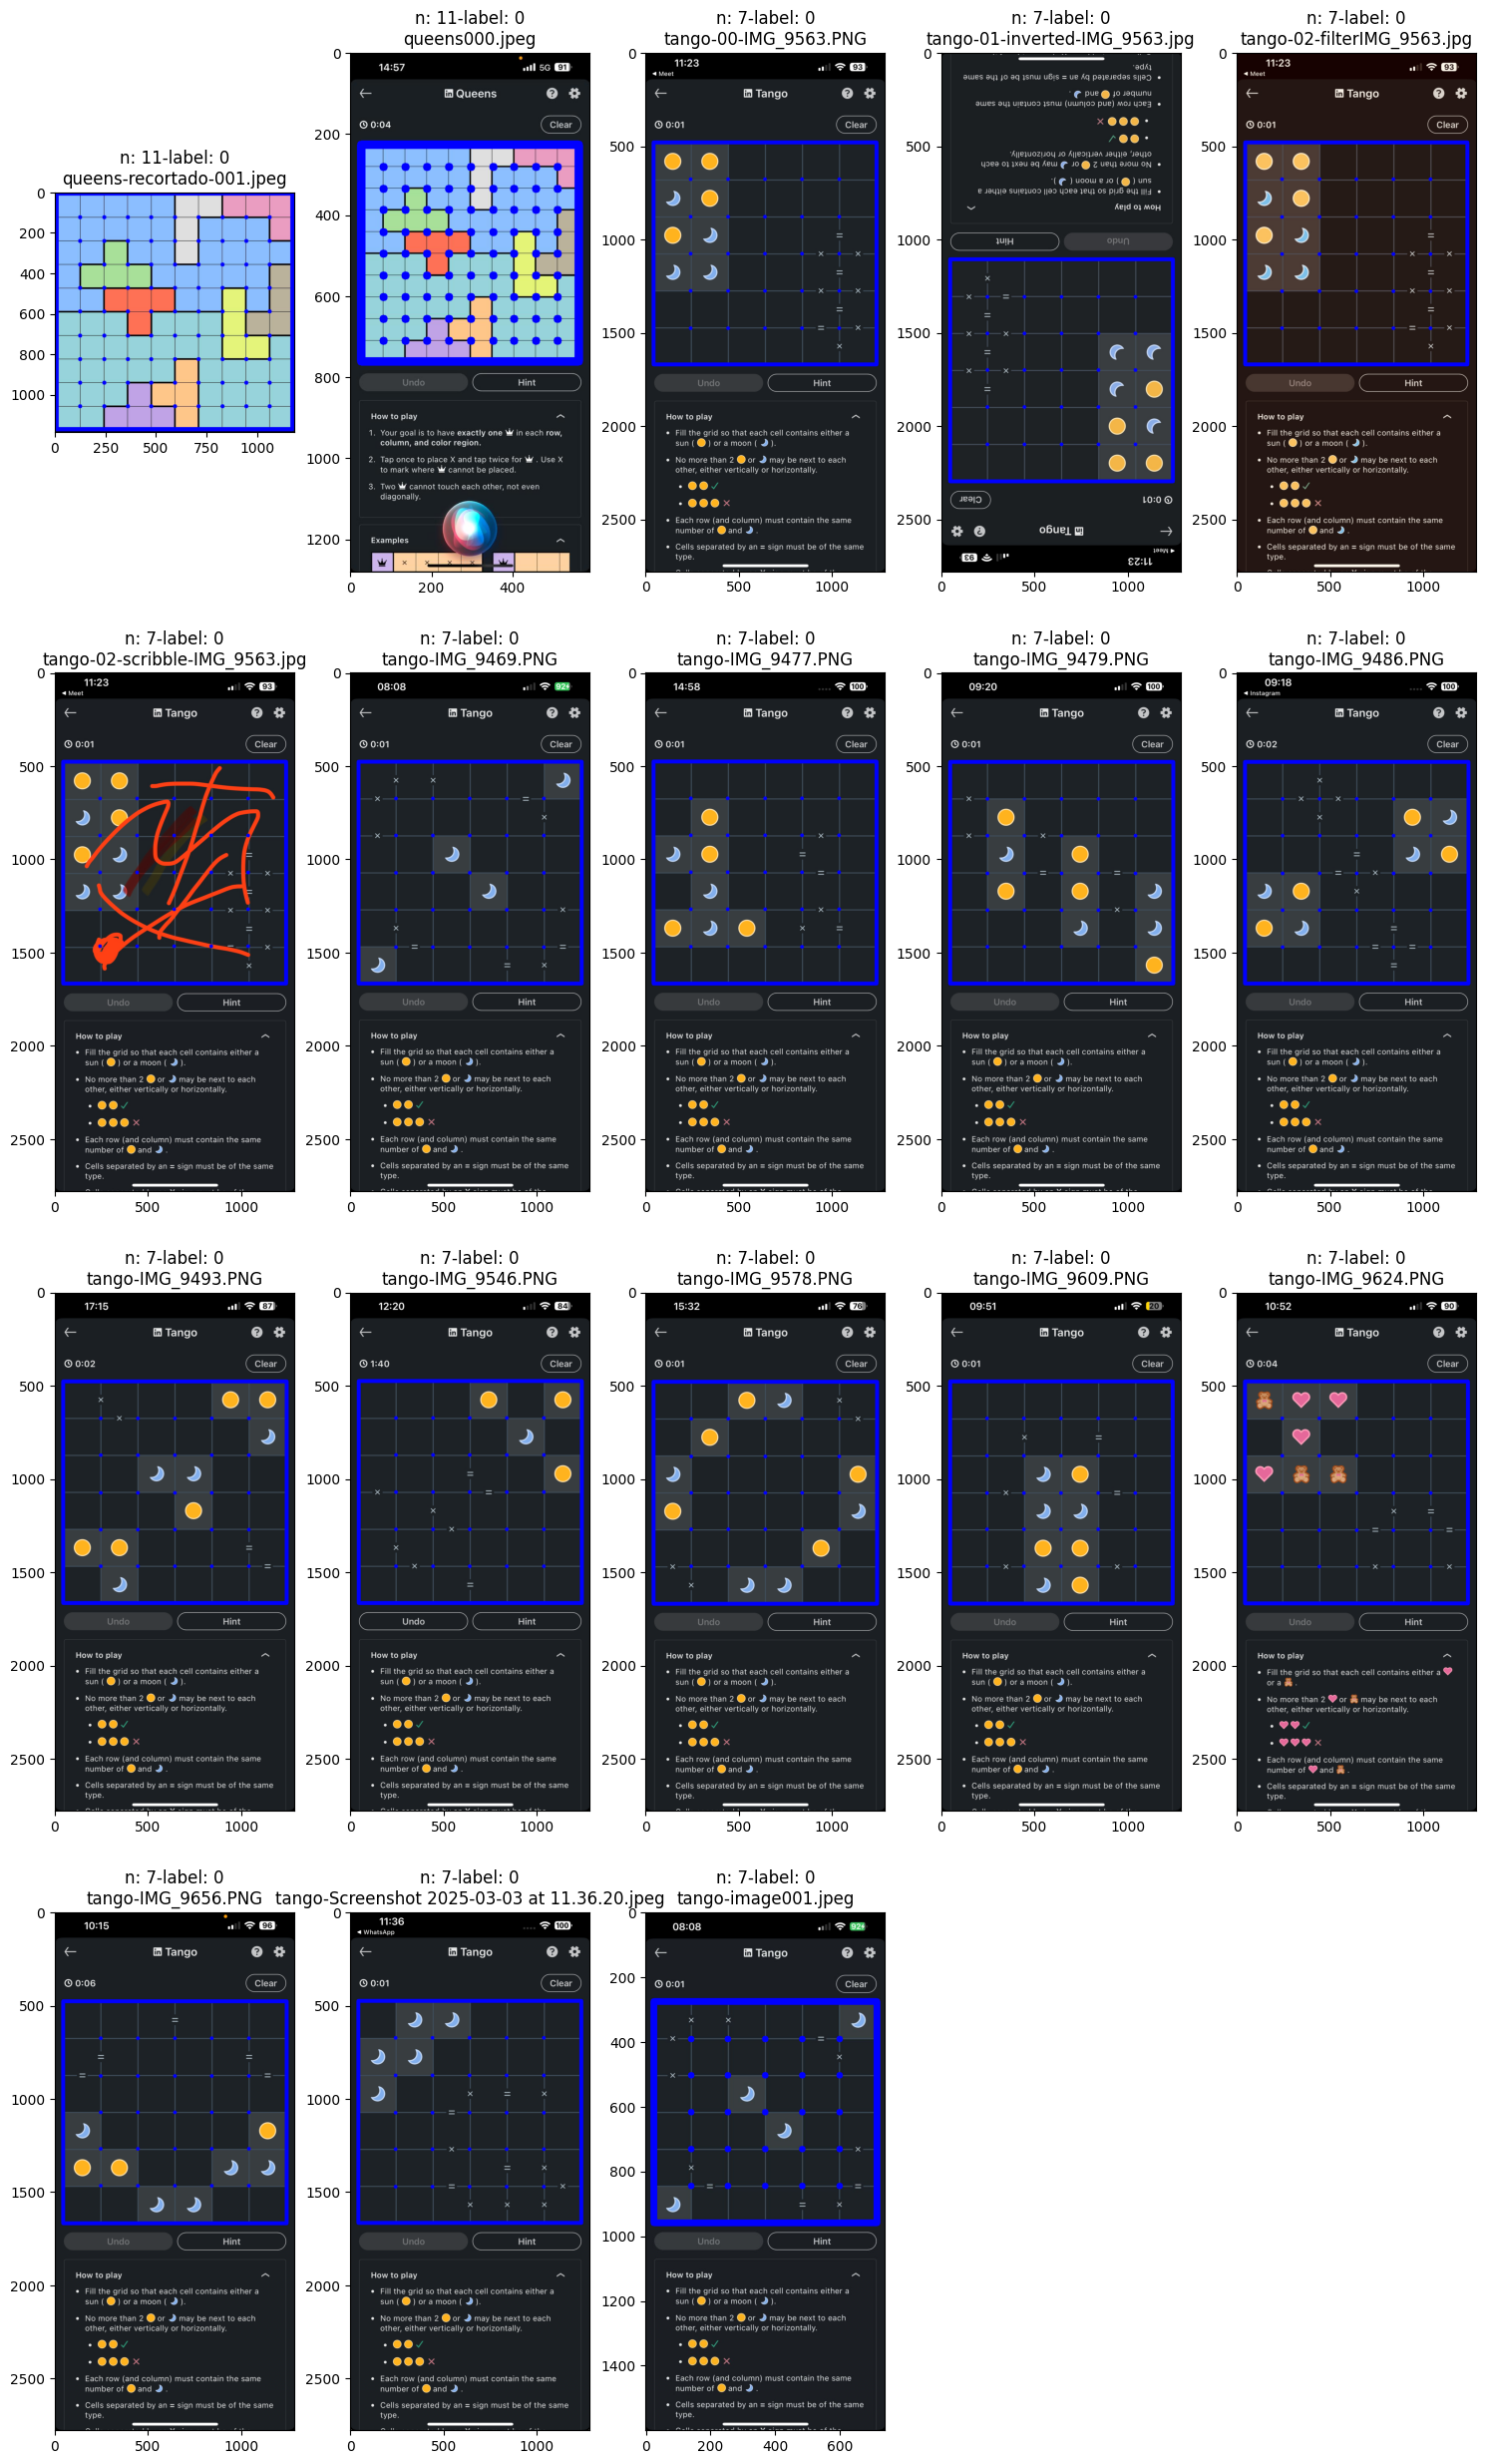

In [15]:
# Show all the grids found

for i in range(0, len(show), 20):
    imshow(show[i:i+20], col_qty=5, axis_off=False, figsize=(15, 25))

Solving a puzzle

OK
OK


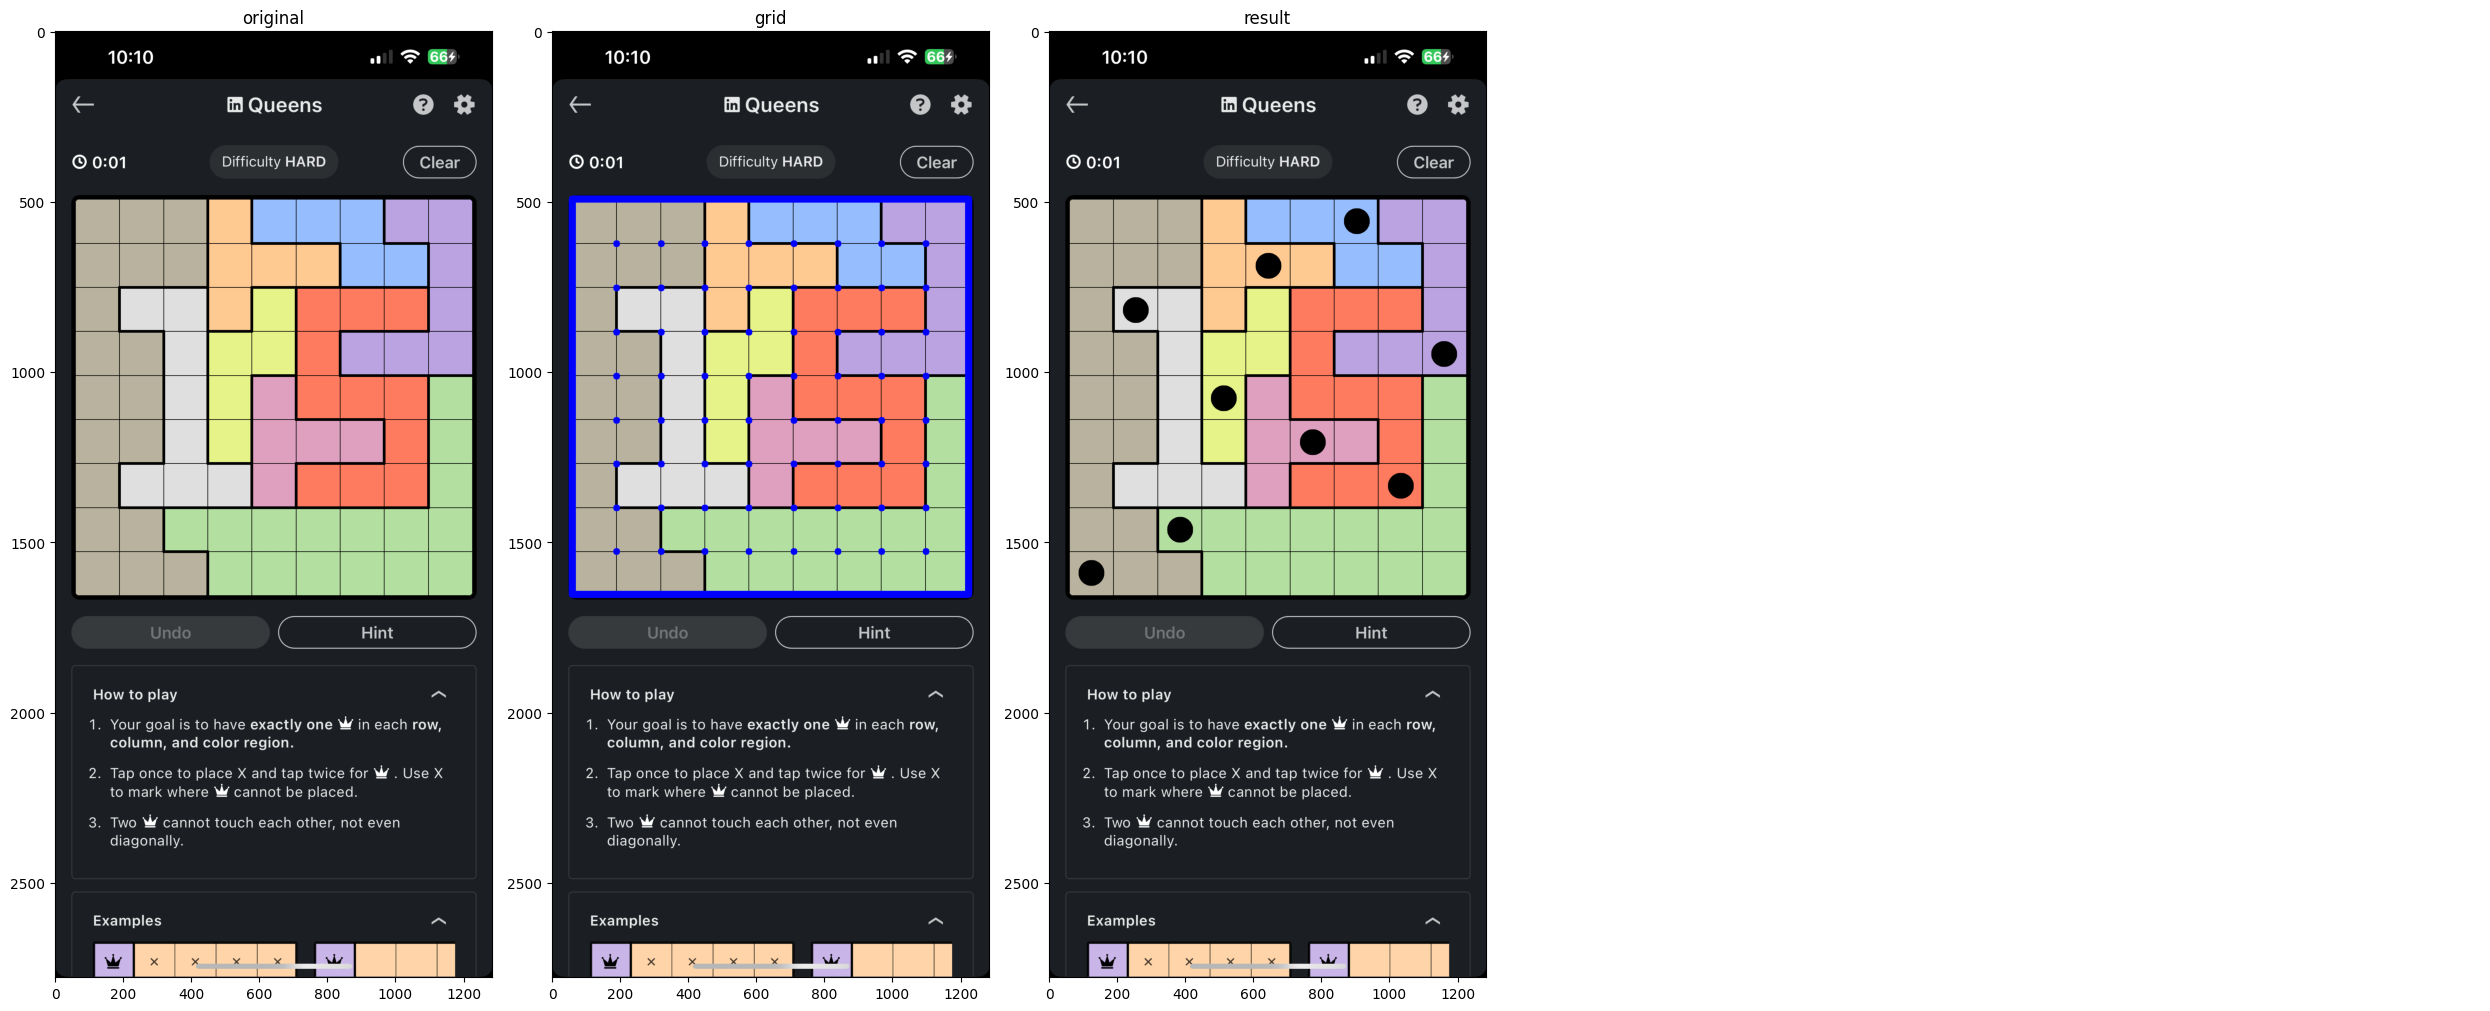

In [16]:
threshold_values = [70, 100, 130, 160]
min_line_length = [300, 350, 400]
max_line_gap = [8, 12]
max_groupping_dist = 3

# Create a BoardPuzzle object

grid = Grid('./img/queens-IMG_9629.PNG')

puzzle = Queens(
    grid, 
    resize_width=500, 
    threshold_value= threshold_values,
    min_line_length= min_line_length, 
    max_line_gap= max_line_gap,
    max_groupping_dist= max_groupping_dist,
    min_valid_n= 6, max_valid_n= 16
)
print(puzzle.msg)

# Solve the puzzle and show the result
solver = BPSolver(puzzle, 1000, timedelta(seconds=120), 20)
msg = solver.solve()
print(msg)

if grid.image is not None:
    imshow(
        [
            ('original', grid.image),
            ('grid', draw_grid(grid.image, grid.x_axis, grid.y_axis)),
            ('result', puzzle.draw_solution(grid.image))
        ],
        axis_off=False,
        figsize=(25, 10)
    )

Solve all the puzzles

In [17]:
# Solve the puzzles

threshold_values = [70, 100, 130, 160]
min_line_length = [300, 350, 400]
max_line_gap = [8, 12]
max_groupping_dist = 3

show = []
results = ''
failed = []
filenames = sorted(glob.glob('./img/*.*'))
start_time, done = datetime.now(), 0
with tqdm(total=len(filenames), desc="Progress", unit="iter") as pbar:
    for filename in filenames:
        # Try to find a Grid
        grid = Grid(filename)
        grid.preprocess_image(resize_width=500, threshold_values=threshold_values)
        grid.find_grid(
            min_line_length=min_line_length, 
            max_line_gap=max_line_gap,
            max_groupping_dist=max_groupping_dist,
            min_valid_n=6, max_valid_n=16
        )
        if grid.n == 0:
            failed.append({'filename': filename, 'fail': 'No grid detected'})
            results += "✖"
            done += 1
            update_pbar(pbar, start_time, done, len(filenames), results)
            continue

        # Try to find a "Queens" board in the image
        puzzle = Queens(grid)
        if puzzle.board is None:
            failed.append({'filename': filename, 'fail': puzzle.msg})
            results += "✖"
            done += 1
            update_pbar(pbar, start_time, done, len(filenames), results)
            continue

        # if found a puzzle, try to solve it
        solver = BPSolver(puzzle, 1000, timedelta(seconds=120), 20)
        msg = solver.solve()

        # show the result
        show.append((
            f"{grid.image_path.replace('./img/', '', 1)}",
            puzzle.draw_solution()
        ))
        if not puzzle.is_solved:
            # add it to the failed list
            failed.append({'filename': filename, 'fail': msg})
            results += "✖"
        else:
            results += "✔"

        # update progress bar
        done += 1
        update_pbar(pbar, start_time, done, len(filenames), results)
        

Progress: 100%|██████████| 78/78 [00:56<00:00,  1.39iter/s, ETA=00:11:45, Status=✔✔✔✔✔✔✖✔✔✔✔✔✔✔✔✔✔✔✖✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔✖✖✖✖✖✖✖✖✖✖✖✖✖✖✖✖]


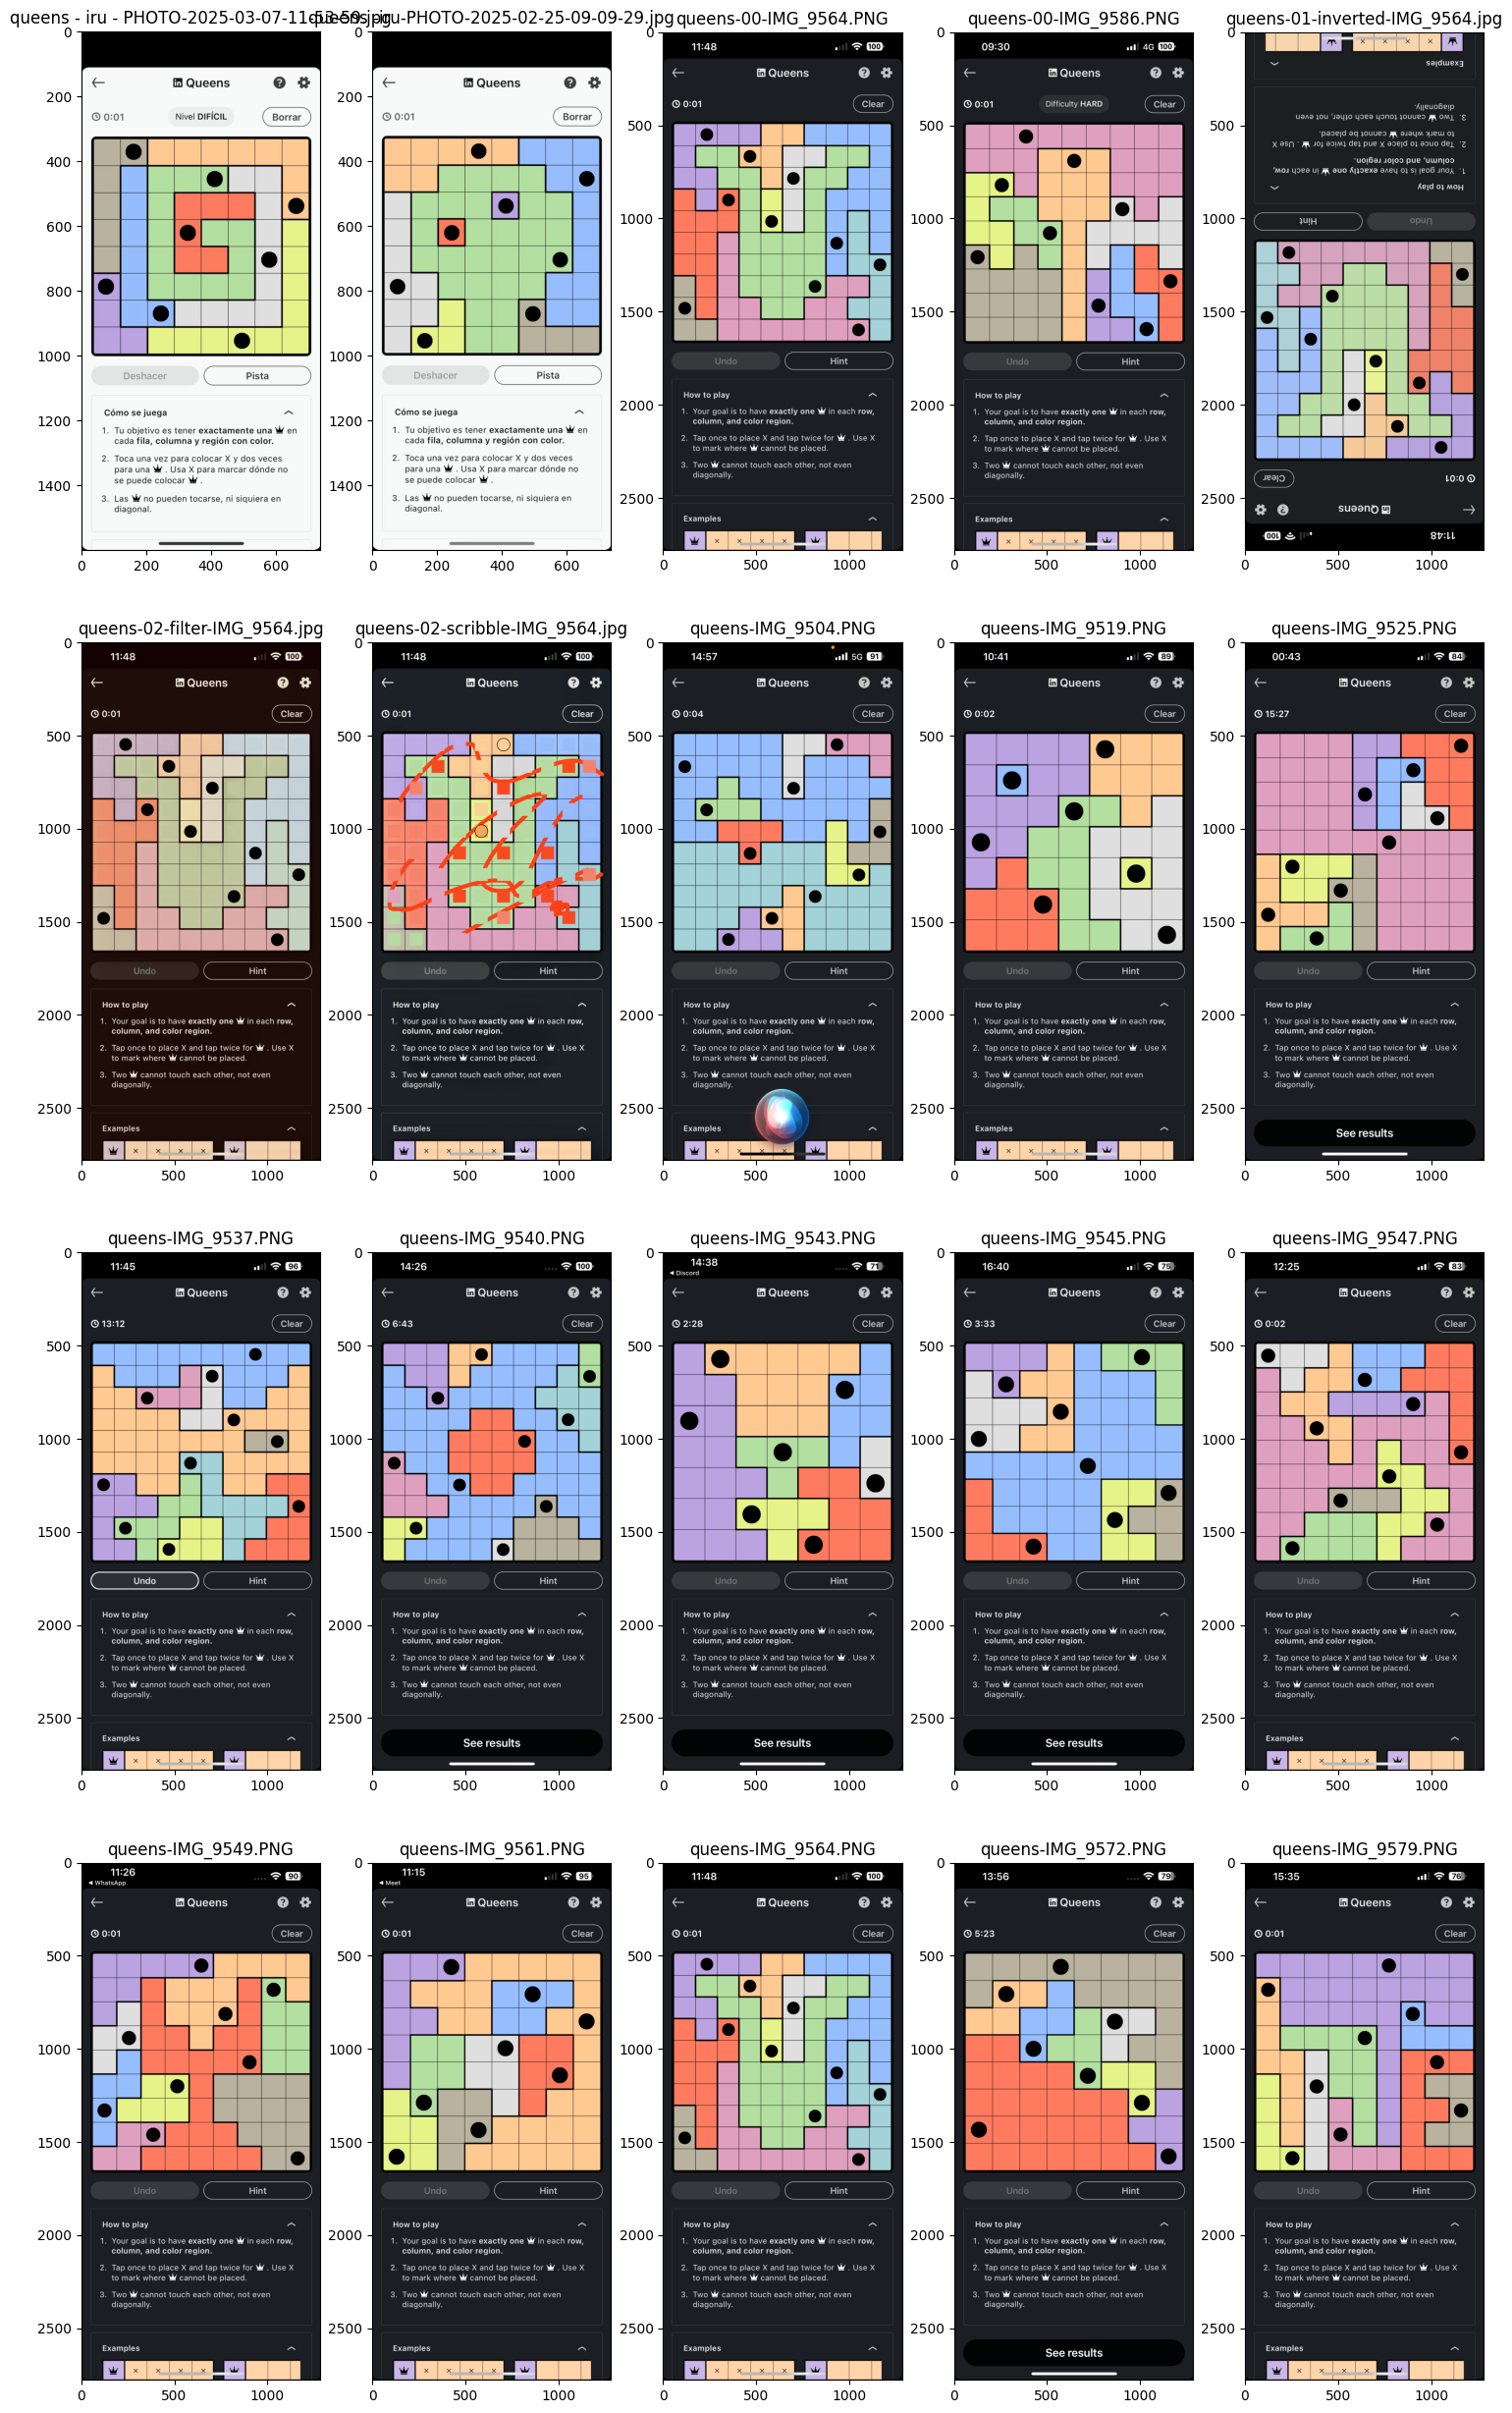

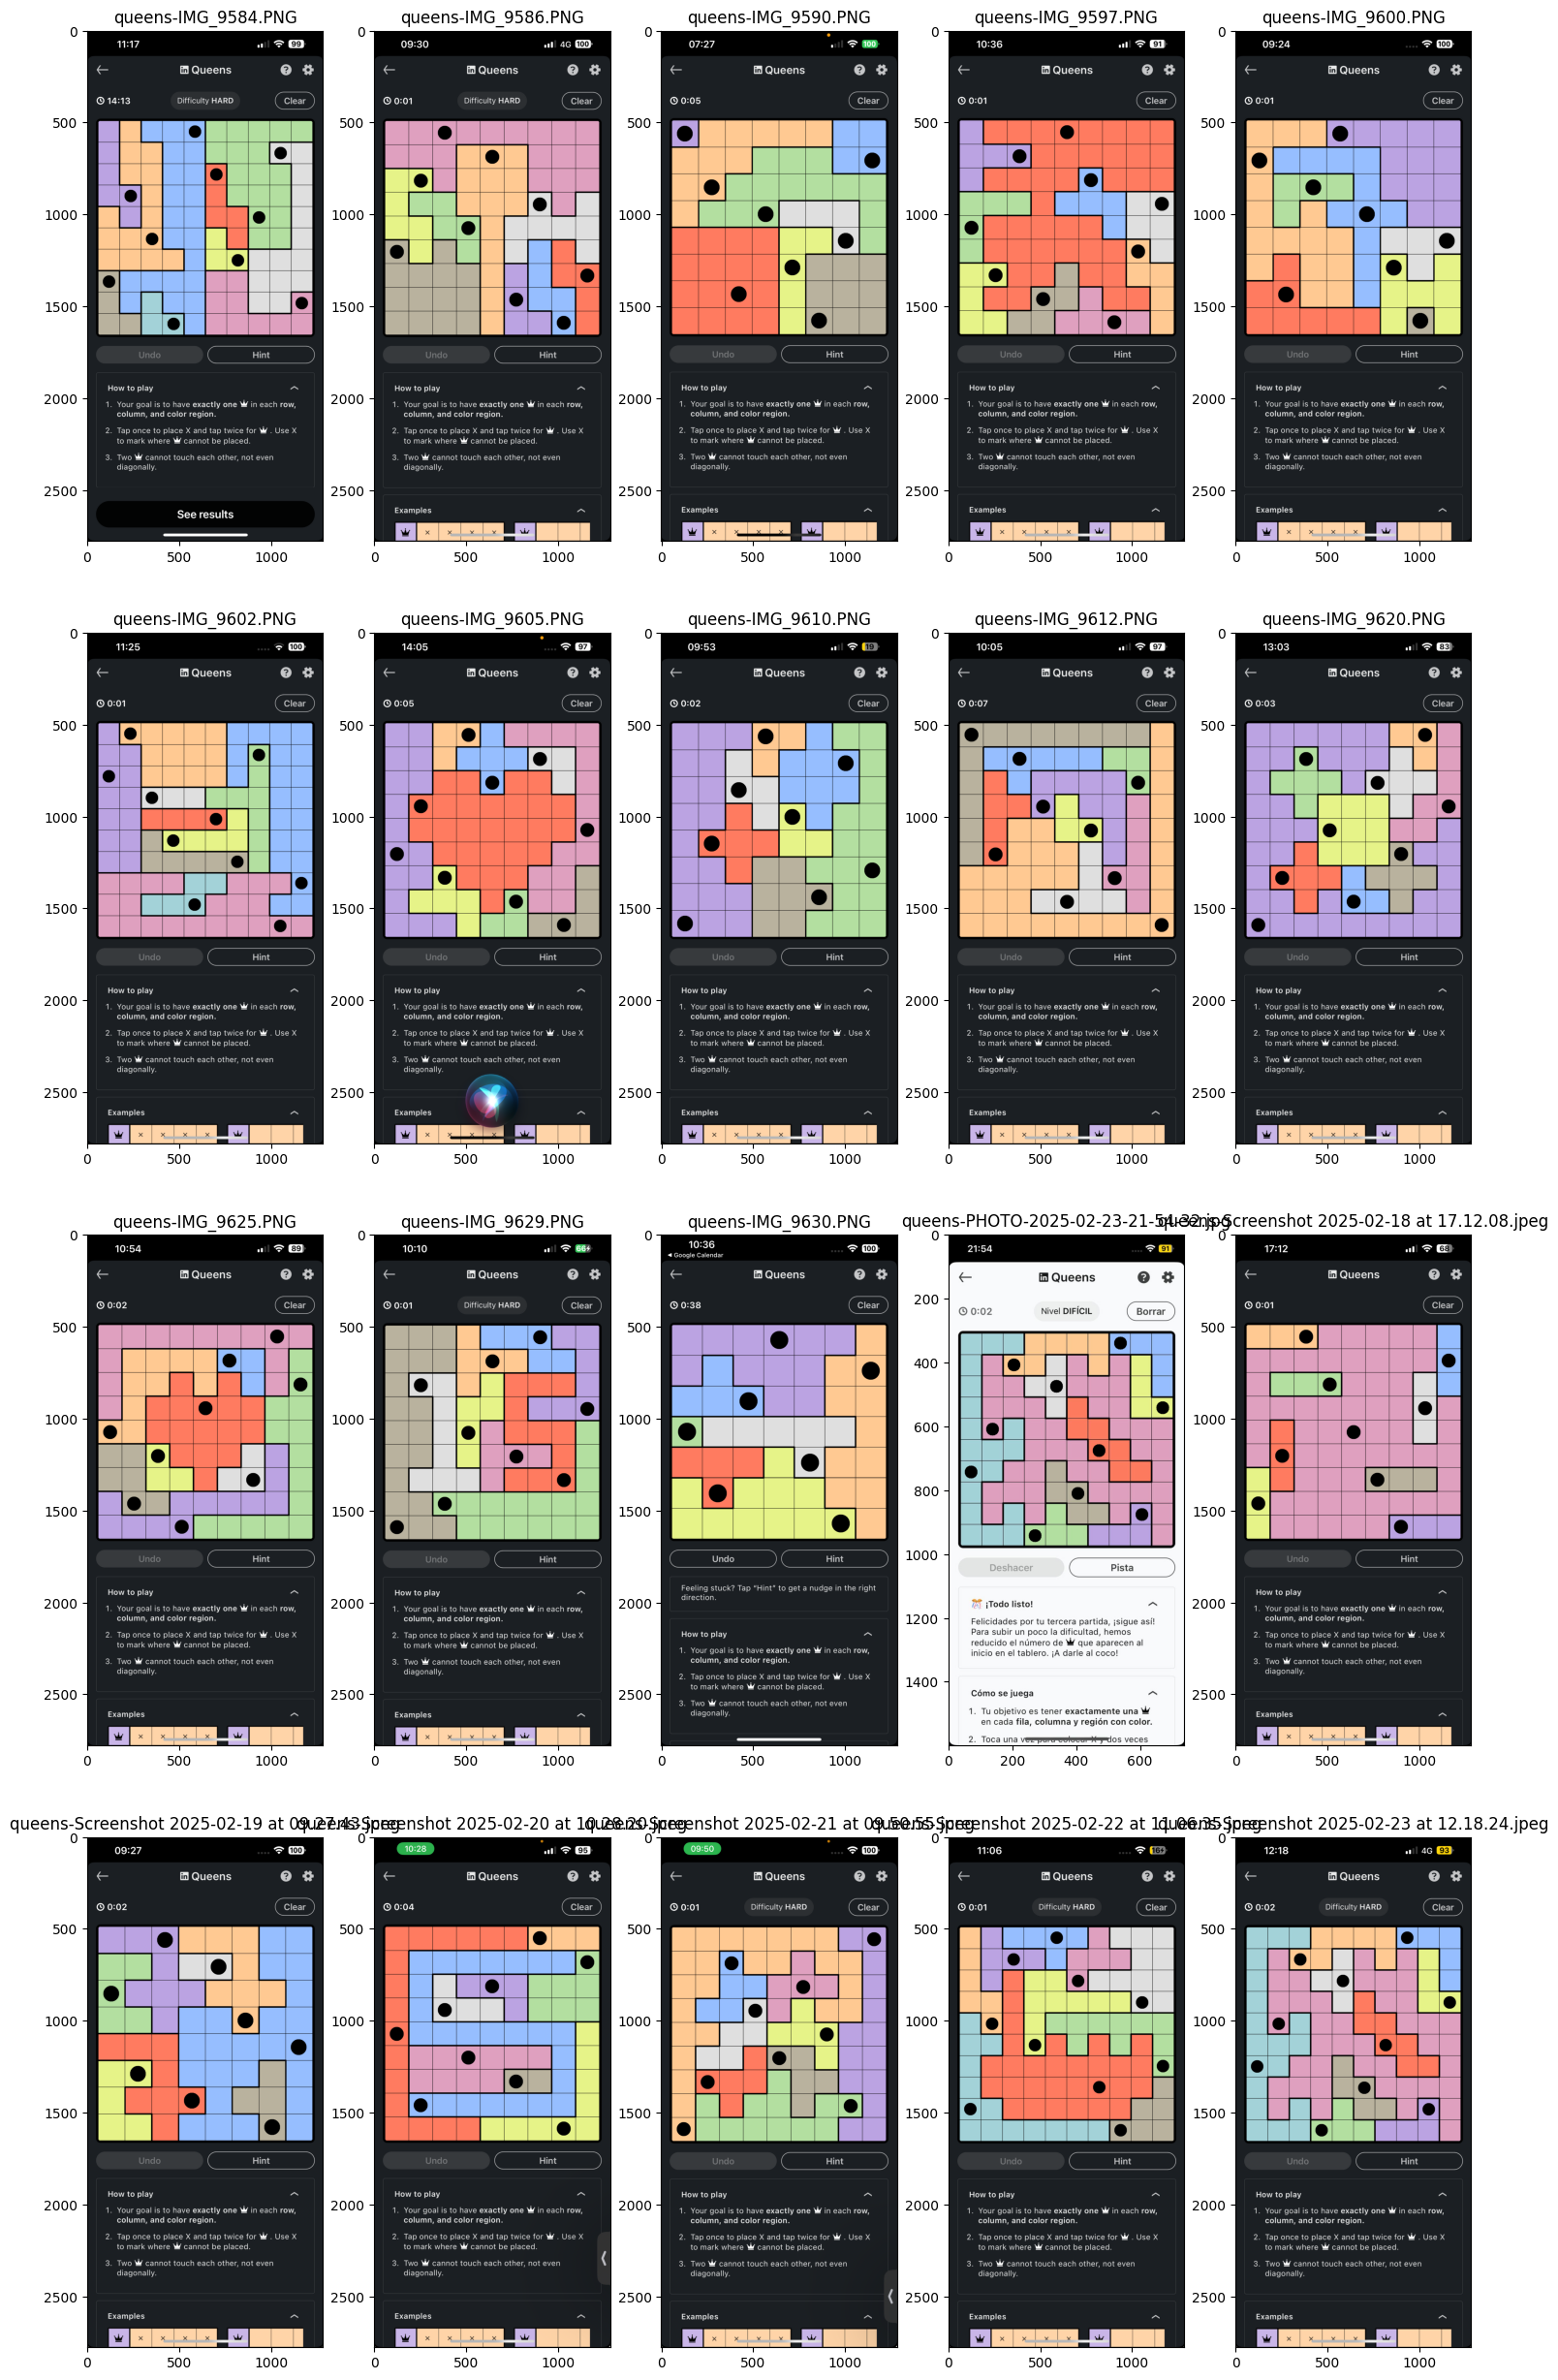

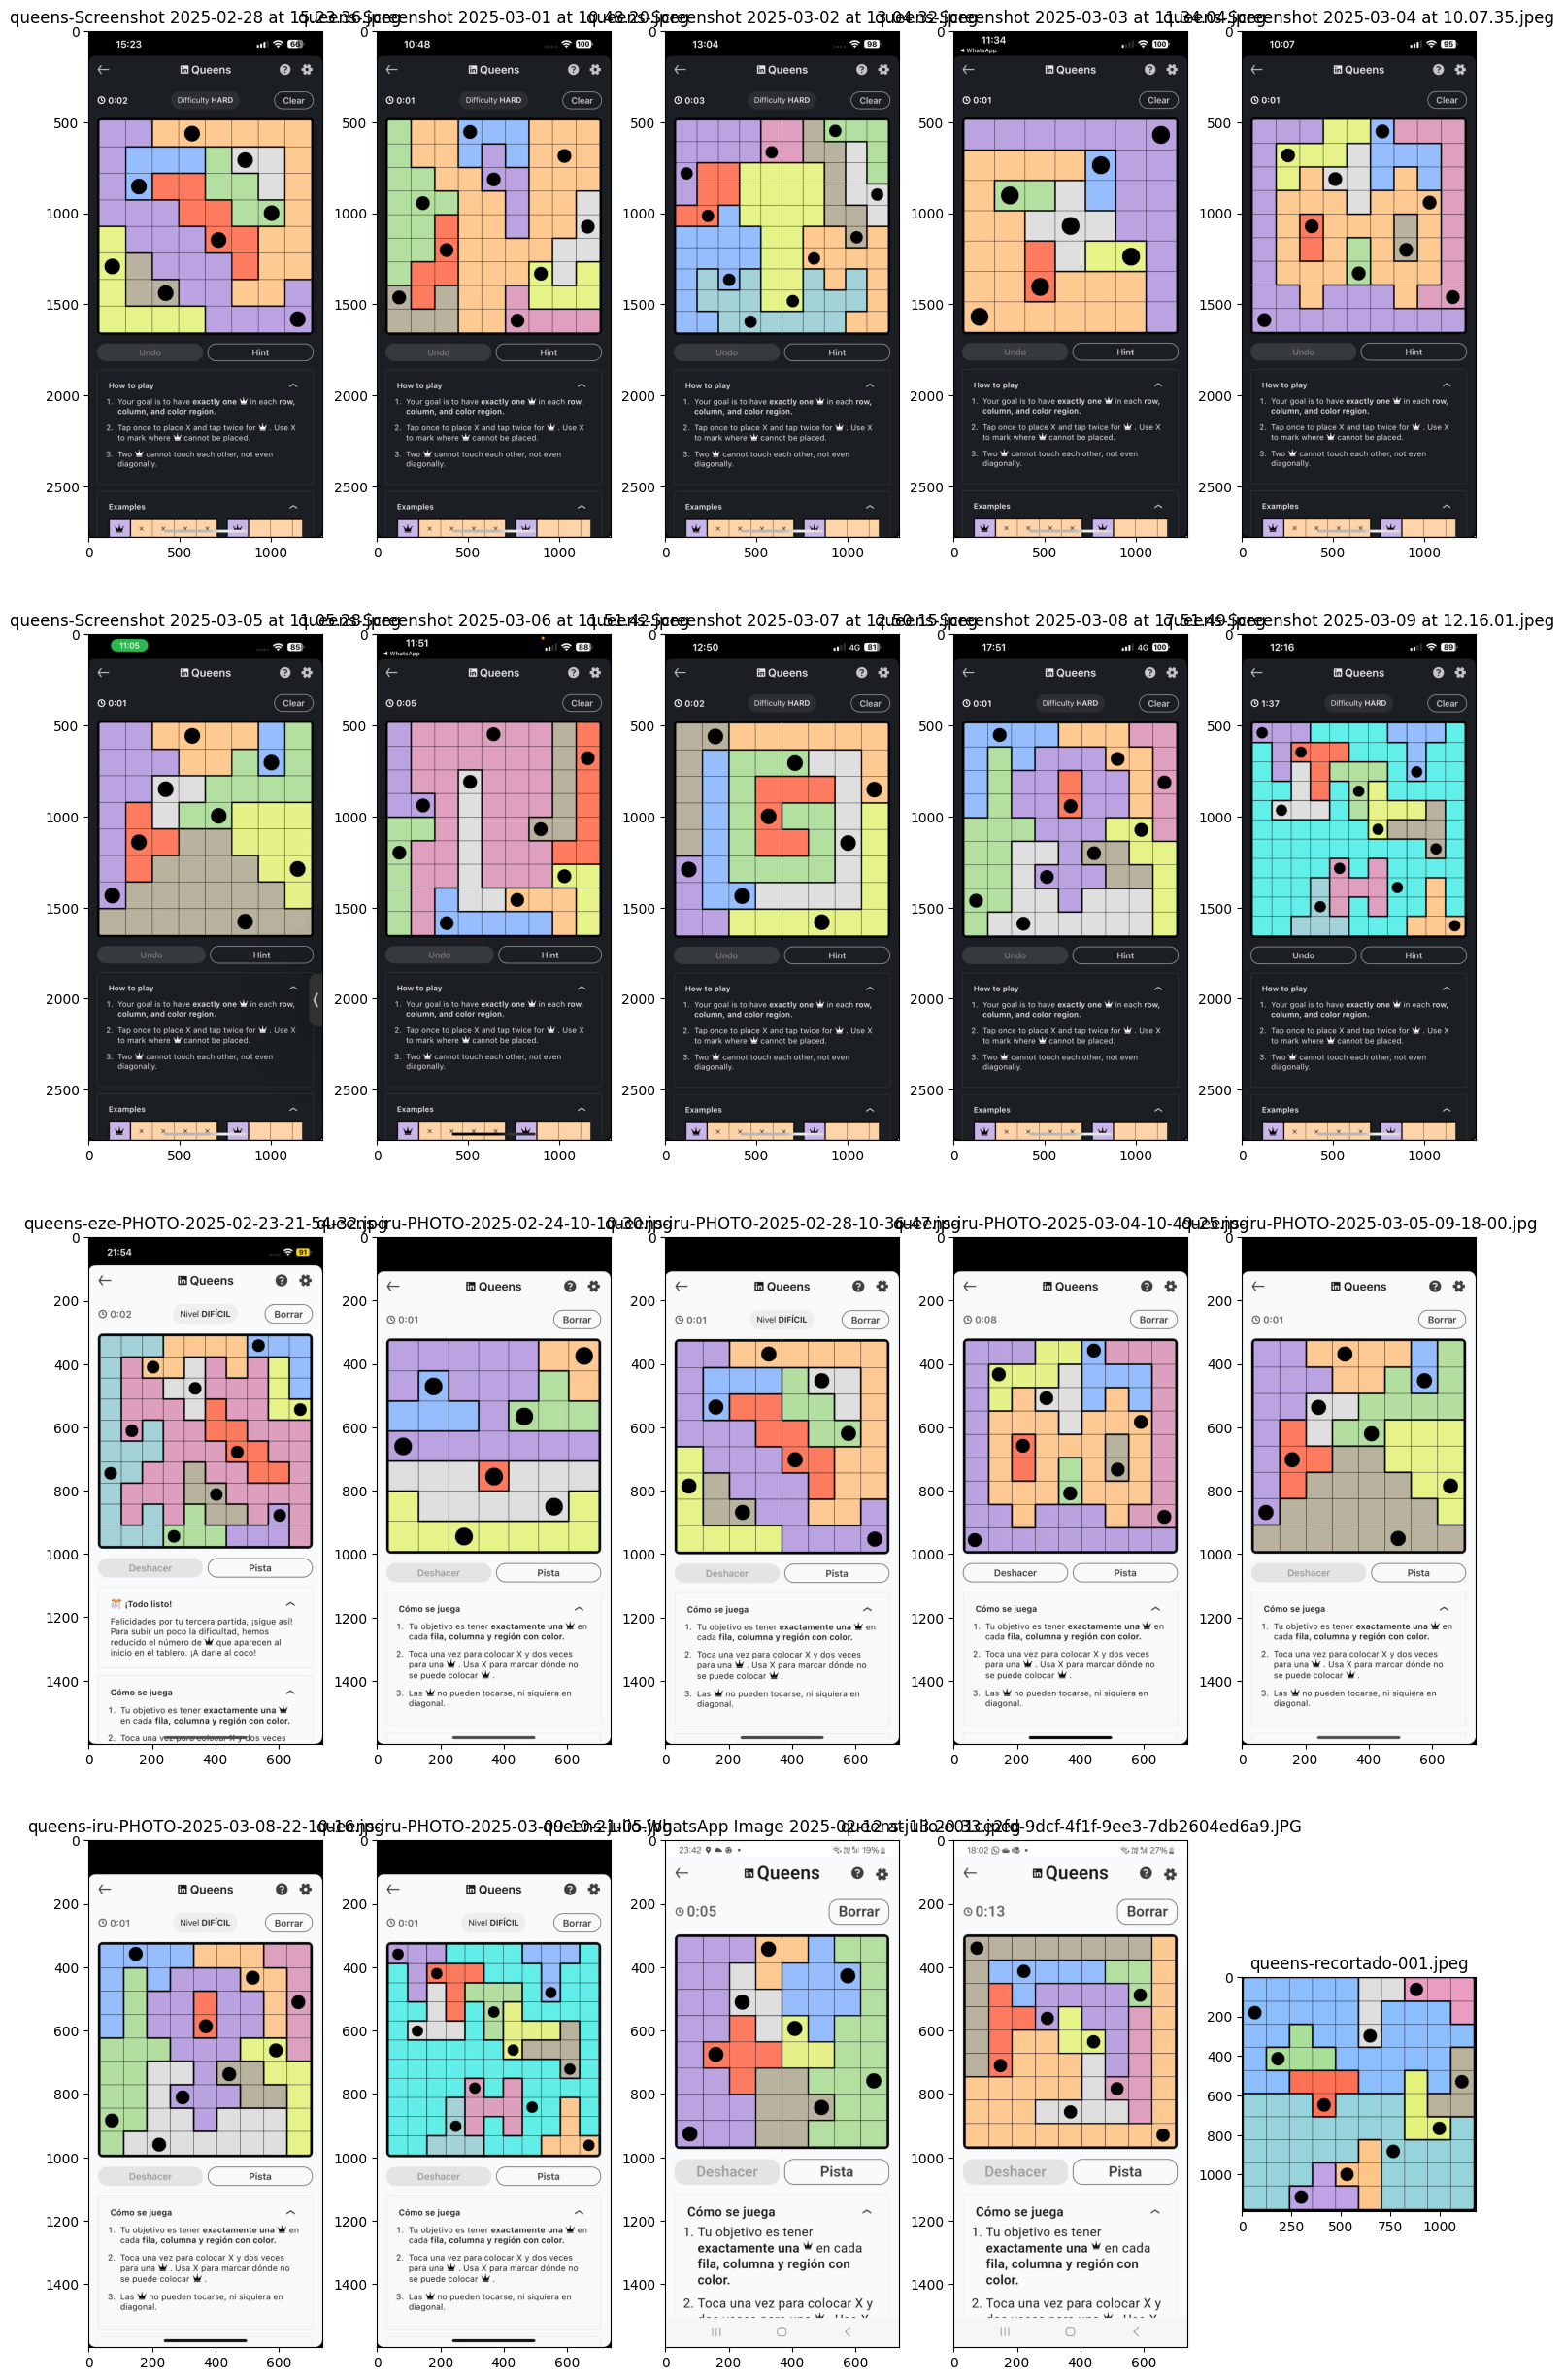

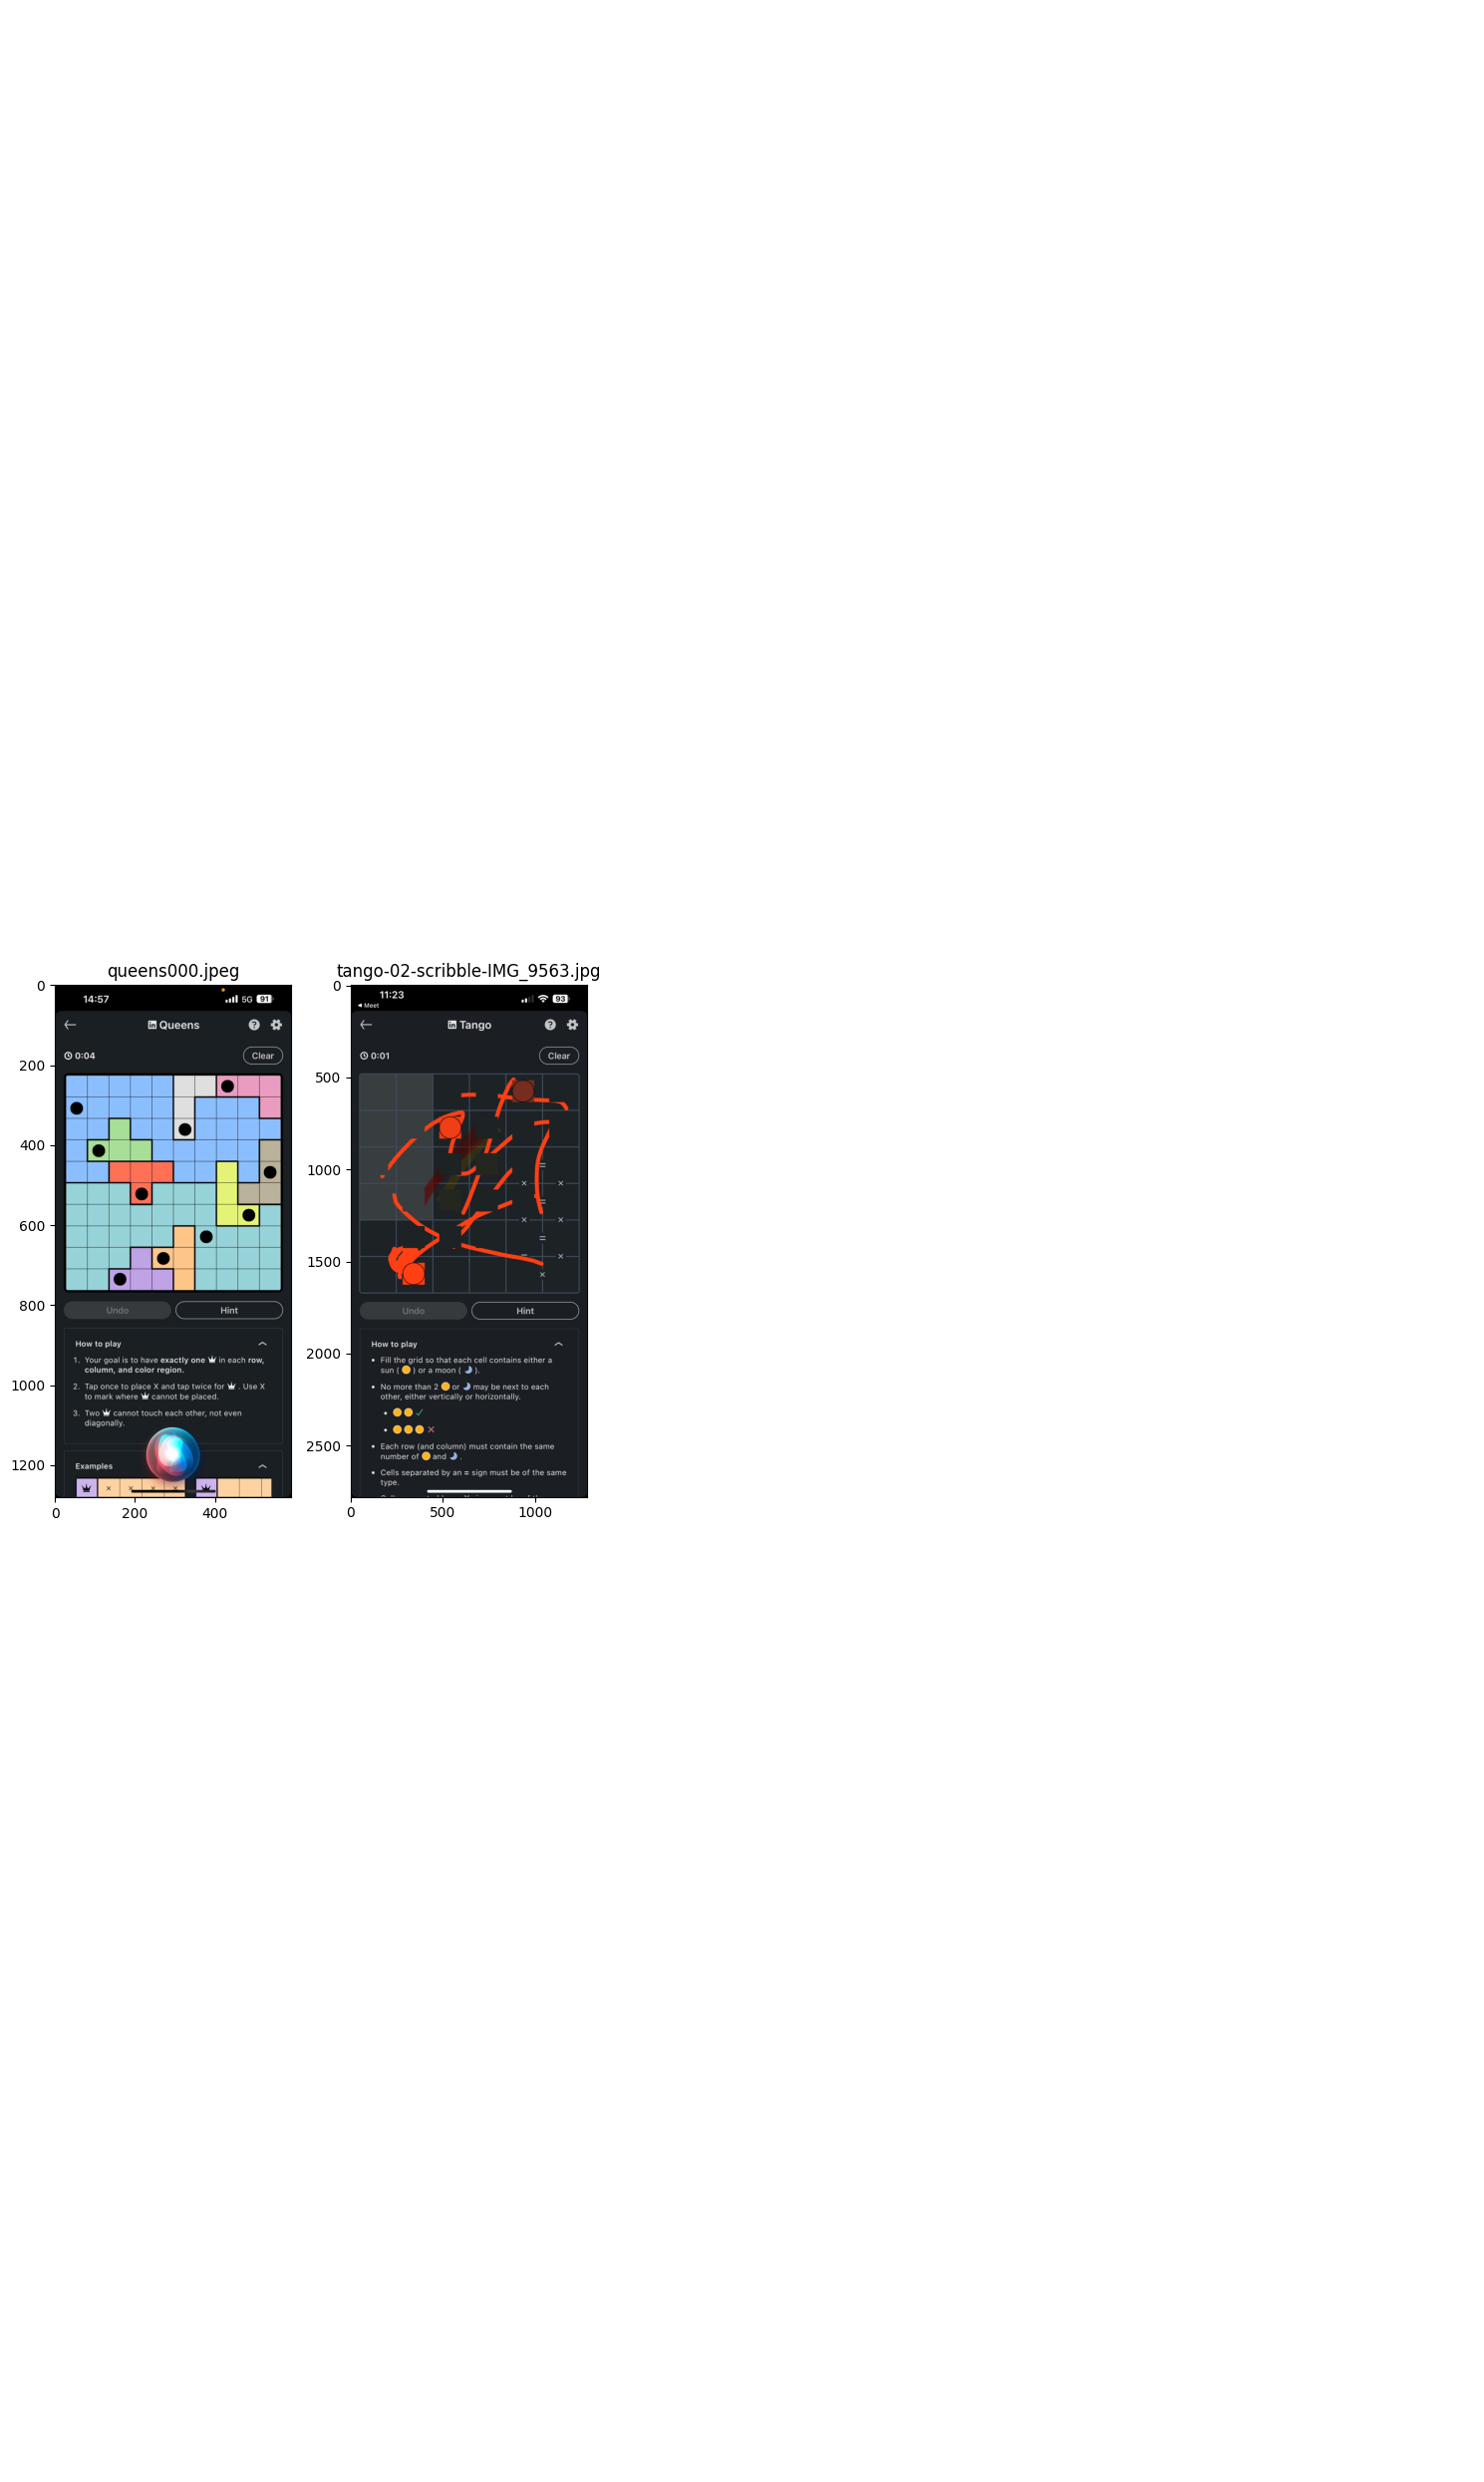

In [18]:
# Show all the results found

for i in range(0, len(show), 20):
    imshow(show[i:i+20], col_qty=5, axis_off=False, figsize=(15, 25))

In [19]:
pd.DataFrame(failed)

filename  \
0               ./img/queens-02-scribble-IMG_9564.jpg   
1                           ./img/queens-IMG_9569.PNG   
2                         ./img/tango-00-IMG_9563.PNG   
3                ./img/tango-01-inverted-IMG_9563.jpg   
4                   ./img/tango-02-filterIMG_9563.jpg   
5                ./img/tango-02-scribble-IMG_9563.jpg   
6                            ./img/tango-IMG_9469.PNG   
7                            ./img/tango-IMG_9477.PNG   
8                            ./img/tango-IMG_9479.PNG   
9                            ./img/tango-IMG_9486.PNG   
10                           ./img/tango-IMG_9493.PNG   
11                           ./img/tango-IMG_9546.PNG   
12                           ./img/tango-IMG_9578.PNG   
13                           ./img/tango-IMG_9609.PNG   
14                           ./img/tango-IMG_9624.PNG   
15                           ./img/tango-IMG_9656.PNG   
16  ./img/tango-Screenshot 2025-03-03 at 11.36.20....   
17                          ./img/tango-image001.jpeg   

                                                 fail  
0                         COULD NOT FIND ANY SOLUTION  
1                                    No grid detected  
2   No valid board detected (6x6 grid and only 2 c...  
3   No valid board detected (6x6 grid and only 3 c...  
4   No valid board detected (6x6 grid and only 2 c...  
5                         COULD NOT FIND ANY SOLUTION  
6   No valid board detected (6x6 grid and only 2 c...  
7   No valid board detected (6x6 grid and only 2 c...  
8   No valid board detected (6x6 grid and only 2 c...  
9   No valid board detected (6x6 grid and only 2 c...  
10  No valid board detected (6x6 grid and only 2 c...  
11  No valid board detected (6x6 grid and only 2 c...  
12  No valid board detected (6x6 grid and only 2 c...  
13  No valid board detected (6x6 grid and only 2 c...  
14  No valid board detected (6x6 grid and only 2 c...  
15  No valid board detected (6x6 grid and only 2 c...  
16  No valid board detected (6x6 grid and only 2 c...  
17  No valid board detected (6x6 grid and only 2 c...